# aT 농산품 예측 base line (ver. TabNet)

&nbsp;

## 1. Import module

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import warnings
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss


import os
import datetime

import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import pyplot as plt

# 경고 끄기
warnings.filterwarnings(action='ignore')

# # 시드고정
# tf.random.set_seed(1215)
# random.seed(1215)
np.random.seed(1215)

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Light.ttc'
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# datetime setting
now = datetime.datetime.now().strftime('%m%d%H%M')

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

&nbsp;

## 2. Data loader, parameter setting

In [22]:
data_list = glob('./data//train/*.csv')
epoch = 1000 # default: 1000
batch = 15 # default: 15
# tr_del_list = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 '] # train 에서 사용하지 않는 열
# ts_del_list = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체평균가격(원)'] # test 에서 사용하지 않는 열
'''
tr_del_list = ['단가(원)', '거래대금(원)', '경매건수', '도매법인코드', '산지코드 '] # train 에서 사용하지 않는 열

ts_del_list = ['단가(원)', '거래대금(원)', '경매건수', '도매법인코드', '산지코드 ', '해당일자_전체평균가격(원)'] # test 에서 사용하지 않는 열

check_col = ['일자구분_중순', '일자구분_초순', '일자구분_하순','월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', 
             '월구분_4월','월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'] # 열 개수 맞추기
'''

tr_del_list = ['산지코드 '] # train 에서 사용하지 않는 열
ts_del_list = ['산지코드 '] # test 에서 사용하지 않는 열

check_col = ['일자구분_중순', '일자구분_초순', '일자구분_하순'] # 열 개수 맞추기


# parameter setting

tabnet_params = dict(cat_emb_dim=1, cat_idxs=cat_idxs, n_d=16, n_a=16, n_steps=2, gamma=1.3,
                     lambda_sparse=0, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type='entmax',
                     scheduler_params=dict(mode="min",
                                           patience=5,
                                           min_lr=1e-5,
                                           factor=0.9,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10,
                     seed=1215
                     )

In [4]:
# cat_features = ['month', 'dayoftheweek', '도매시장코드', '도매법인코드', '일자구분_중순', '일자구분_초순', '일자구분_하순']
cat_features = ['month', 'dayoftheweek', '도매시장코드', '도매법인코드']

cat_del = ['월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', 
             '월구분_4월','월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월']

In [5]:
i = data_list[3]
df_number = i.split("_")[-1].split(".")[0]
df = pd.read_csv(i)

for j in df.columns: 
    df[j] = df[j].replace({' ': np.nan})

# 사용할 열 선택 및 index 설정
df.drop(tr_del_list, axis=1, inplace=True)

df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df.drop('datadate', axis=1, inplace=True)

# df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayoftheweek'] = df['datetime'].dt.day_of_week

df.drop(cat_del, axis=1, inplace=True)

df.set_index('datetime', drop=True, inplace=True)

# df.set_index('datadate', drop=True, inplace=True)

# nan 처리
df = df.fillna(0)

# to categorical type
# for NUM_i in range(1,3):
#     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

for i_ca in enumerate(cat_features) :
    ca = i_ca[1]
    df[ca] = df[ca].astype("category")

# 변수와 타겟 분리
# x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
x, y = df, df['해당일자_전체평균가격(원)']

# type 변경
x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

# 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
y = y[14:]
y = y.replace(0, y.mean())
# y = y.replace(0, 1)

# y의 길이와 같은 길이로 설정
xdata = x[:len(y)]
ydata = pd.Series.to_frame(y)

In [12]:

# tabnet categorical

from sklearn.preprocessing import LabelEncoder

categorical_columns = []
categorical_dims = {}

for col in xdata.columns[xdata.dtypes == 'category']:
    print(col, xdata[col].nunique())
    l_enc = LabelEncoder()
    # xdata[col] = xdata[col].fillna('VV_likely')
    xdata[col] = l_enc.fit_transform(xdata[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

# for col in xdata.columns[xdata.dtypes == 'float64']:
#     xdata.fillna(xdata.loc[xdata])


도매시장코드 31
도매법인코드 72
month 12
dayoftheweek 7


In [13]:
features = [col for col in xdata.columns]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f]
            for i, f in enumerate(features) if f in categorical_columns]
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]


In [17]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

Device used : cuda


In [14]:

print(features)
print(cat_idxs)
print(cat_dims)


['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)', '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)', '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)', '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)', '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_0_습도(%)', '주산지_1_초기온도(℃)', '주산지_1_최대온도(℃)', '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)', '주산지_1_습도(%)', '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)', '주산지_2_평균온도(℃)', '주산지_2_강수량(ml)', '주산지_2_습도(%)', '일자구분_중순', '일자구분_초순', '일자구분_하순', 'month', 'dayoftheweek']
[4, 5, 44, 45]
[31, 72, 12, 7]


## Train 과정

In [18]:
from sklearn.metrics import log_loss
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import roc_auc_score, log_loss, mean_squared_error

class LogitsLogLoss(Metric):
    """
    LogLoss with sigmoid applied
    """

    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        """
        Compute LogLoss of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            LogLoss of predictions vs targets.
        """
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1-y_true)*np.log(1-logits+1e-15) + y_true*np.log(logits+1e-15)
        return np.mean(-aux)


def rmse(y_true, y_pred):
    return mean_squared_error(y_true,y_pred, squared=False)
def rmspe(y_true, y_pred):
    # Function to calculate the root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


def rmspe_(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    
    if (y_true == 0).any():
        raise ValueError("Root Mean Square Percentage Error cannot be used when "
                         "targets contain zero values.")
        
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0)).item()

    return loss


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))


def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()



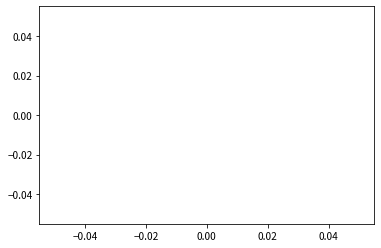

In [16]:
# plot
plt.plot(tabnet_model.history['loss'])
# plt.plot(tabnet_model.history['val_rmse'])
plt.plot(tabnet_model.history['lr'])

In [23]:
# tabnet sample simple
from pytorch_tabnet.tab_model import TabNetRegressor


i = data_list[3]
df_number = i.split("_")[-1].split(".")[0]
df = pd.read_csv(i)

for j in df.columns:
    df[j] = df[j].replace({' ': np.nan})

# 사용할 열 선택 및 index 설정
df.drop(tr_del_list, axis=1, inplace=True)

df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df.drop('datadate', axis=1, inplace=True)

# df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayoftheweek'] = df['datetime'].dt.day_of_week

df.drop(cat_del, axis=1, inplace=True)

df.set_index('datetime', drop=True, inplace=True)

# df.set_index('datadate', drop=True, inplace=True)

# nan 처리
df = df.fillna(0)

# to categorical type
# for NUM_i in range(1,3):
#     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

for i_ca in enumerate(cat_features):
    ca = i_ca[1]
    df[ca] = df[ca].astype("category")

# 변수와 타겟 분리
# x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
x, y = df, df['해당일자_전체평균가격(원)']

# type 변경
x = x.astype({'주산지_0_습도(%)': 'float64',
              '주산지_1_습도(%)': 'float64', '주산지_2_습도(%)': 'float64'})

# 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
y = y[14:]
y = y.replace(0, y.mean())
# y = y.replace(0, 1)

# y의 길이와 같은 길이로 설정
xdata = x[:len(y)]
ydata = pd.Series.to_frame(y)

X_train, X_val, y_train, y_val = train_test_split(
    xdata.values, ydata.values, test_size=0.2, shuffle=False, random_state=1215)

clf = TabNetRegressor(**tabnet_params)
clf.fit(
    X_train=X_train, y_train=y_train, 
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=200,
    patience=20,
    batch_size=128*2, virtual_batch_size=16*2,
    num_workers=0,
    drop_last=False,
    # augmentations=aug, #aug
)
# preds = clf.predict(X_val)


Device used : cuda
epoch 0  | loss: 13327092.75972| train_rmsle: 45.62433| train_mae: 3370.24688| train_rmse: 3646.28652| train_mse: 13295405.4046| valid_rmsle: 45.1058 | valid_mae: 3471.55133| valid_rmse: 3771.65765| valid_mse: 14225401.42659|  0:00:00s
epoch 10 | loss: 12963923.63872| train_rmsle: 26.72095| train_mae: 3327.83316| train_rmse: 3595.3168| train_mse: 12926302.9097| valid_rmsle: 30.54371| valid_mae: 3440.94373| valid_rmse: 3732.03357| valid_mse: 13928074.56559|  0:00:03s
epoch 20 | loss: 11914116.24978| train_rmsle: 16.01621| train_mae: 3206.59708| train_rmse: 3451.90346| train_mse: 11915637.49753| valid_rmsle: 19.77838| valid_mae: 3359.51375| valid_rmse: 3630.04444| valid_mse: 13177222.64466|  0:00:07s
epoch 30 | loss: 10178454.25151| train_rmsle: 12.67082| train_mae: 2989.23806| train_rmse: 3201.62606| train_mse: 10250409.45986| valid_rmsle: 15.93173| valid_mae: 3183.53052| valid_rmse: 3435.4356| valid_mse: 11802217.78073|  0:00:10s
epoch 40 | loss: 8058734.16724| train

mse: 995085.38
rmse: 997.54


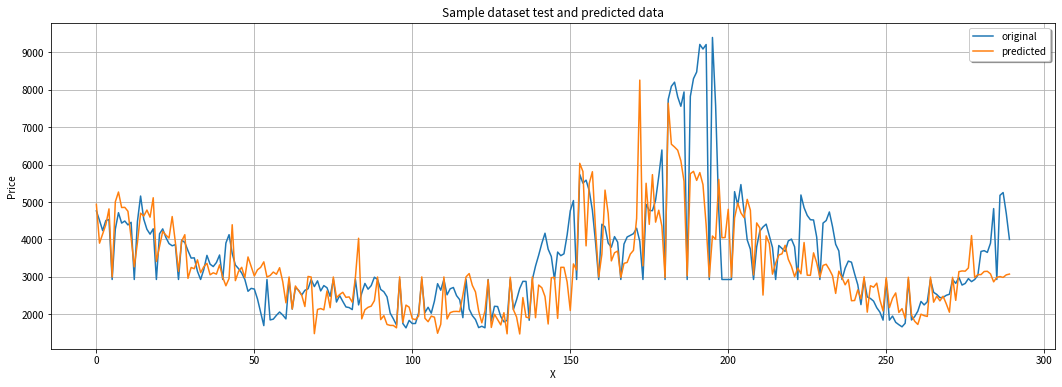

In [24]:
preds = clf.predict(X_val)

mse_ = mean_squared_error(y_val, preds)
rmse_ = mse_**(0.5)
print("mse: %.2f" % mse_)
print("rmse: %.2f" % rmse_)

x_ax = range(len(y_val))
plt.figure(figsize=(18, 6))
plt.plot(x_ax, y_val, label="original")
plt.plot(x_ax, preds, label="predicted")
plt.title("Sample dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [31]:
# tabnet sample

i = data_list[0]
df_number = i.split("_")[-1].split(".")[0]
df = pd.read_csv(i)

for j in df.columns: 
    df[j] = df[j].replace({' ': np.nan})

# 사용할 열 선택 및 index 설정
df.drop(tr_del_list, axis=1, inplace=True)

df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df.drop('datadate', axis=1, inplace=True)

# df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayoftheweek'] = df['datetime'].dt.day_of_week

df.drop(cat_del, axis=1, inplace=True)

df.set_index('datetime', drop=True, inplace=True)

# df.set_index('datadate', drop=True, inplace=True)

# nan 처리
df = df.fillna(0)

# to categorical type
# for NUM_i in range(1,3):
#     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

for i_ca in enumerate(cat_features) :
    ca = i_ca[1]
    df[ca] = df[ca].astype("category")

# 변수와 타겟 분리
# x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
x, y = df, df['해당일자_전체평균가격(원)']

# type 변경
x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

# 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
y = y[14:]
y = y.replace(0, y.mean())
# y = y.replace(0, 1)

# y의 길이와 같은 길이로 설정
xdata = x[:len(y)]
ydata = pd.Series.to_frame(y)

x_train, x_val, y_train, y_val = train_test_split(xdata.values, ydata.values, test_size=0.2, shuffle=True, random_state=1215)

tabnet_model = TabNetRegressor(**tabnet_params)

tabnet_model.fit(X_train=x_train,
                y_train=y_train,
                eval_set=[(x_val, y_val)],
                eval_name = ["val"],
                eval_metric = ["rmse"],
                max_epochs=epoch,
                patience=20, batch_size=128, virtual_batch_size=16, # patience=20, batch_size=256, virtual_batch_size=64,
                num_workers=1, drop_last=False,
                # use binary cross entropy as this is not a regression problem
                loss_fn=RMSPELoss) # loss_fn=torch.nn.functional.binary_cross_entropy_with_logits) # loss_fn=RMSPELoss

tabnet_model.save_model(f'./model{now}/tabnet-{df_number}-{epoch}-{batch}')

Device used : cuda
epoch 0  | loss: 0.99965 | val_rmse: 2186.6854|  0:00:00s
epoch 10 | loss: 0.81071 | val_rmse: 1867.34841|  0:00:08s
epoch 20 | loss: 0.46187 | val_rmse: 1349.14273|  0:00:16s
epoch 30 | loss: 0.41932 | val_rmse: 1041.49653|  0:00:24s
epoch 40 | loss: 0.34345 | val_rmse: 1038.25469|  0:00:32s
epoch 50 | loss: 0.33187 | val_rmse: 1061.07306|  0:00:39s
epoch 60 | loss: 0.34993 | val_rmse: 1082.71133|  0:00:47s
epoch 70 | loss: 0.31617 | val_rmse: 1040.21965|  0:00:54s
epoch 80 | loss: 0.31888 | val_rmse: 1028.55936|  0:01:01s
epoch 90 | loss: 0.29537 | val_rmse: 1036.58509|  0:01:08s
epoch 100| loss: 0.28552 | val_rmse: 1025.86087|  0:01:16s
epoch 110| loss: 0.28603 | val_rmse: 1014.20959|  0:01:23s
epoch 120| loss: 0.29257 | val_rmse: 1019.3737|  0:01:30s

Early stopping occurred at epoch 127 with best_epoch = 107 and best_val_rmse = 988.93868
Best weights from best epoch are automatically used!
Successfully saved model at ./model09290813/tabnet-7-1000-15.zip


'./model09290813/tabnet-7-1000-15.zip'

Device used : cuda
mse: 1832726.34
rmse: 1353.78


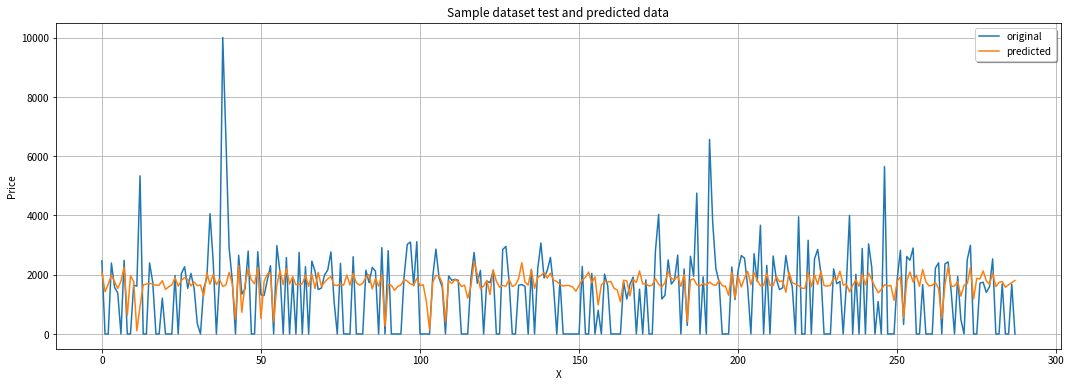

In [32]:
#### sample evaluation
# 0 ~ 36
NUM = 7

## model load
tabnet_model_load = TabNetRegressor(**tabnet_params)
tabnet_model_load.load_model(f'./model{now}/tabnet-{NUM}-1000-15.zip')

df = pd.read_csv(f'./data/train/train_{NUM}.csv')

for j in df.columns:
	df[j] = df[j].replace({' ': np.nan})

# 사용할 열 선택 및 index 설정
df.drop(tr_del_list, axis=1, inplace=True)

df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df.drop('datadate', axis=1, inplace=True)

# df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayoftheweek'] = df['datetime'].dt.day_of_week

df.drop(cat_del, axis=1, inplace=True)

df.set_index('datetime', drop=True, inplace=True)

# df.set_index('datadate', drop=True, inplace=True)

# nan 처리
df = df.fillna(0)

# to categorical type
# for NUM_i in range(1,3):
#     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

for i_ca in enumerate(cat_features) :
	ca = i_ca[1]
	df[ca] = df[ca].astype("category")

# 변수와 타겟 분리
# x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
x, y = df, df['해당일자_전체평균가격(원)']

# type 변경
x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

# 4주 입력을 통한 이후 4주 예측을 위해 y의 첫 21일을 제외
y = y[21:]


# y의 길이와 같은 길이로 설정
xdata = x[:len(y)]
ydata = pd.Series.to_frame(y)

x_train, x_val, y_train, y_val = train_test_split(xdata.values, ydata.values, test_size=0.2, shuffle=True, random_state=1215)


# mse check
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_pred = tabnet_model_load.predict(x_val)
# y_val = y_val.fillna(0)

mse_ = mean_squared_error(y_val, y_pred)
rmse_ = mse_**(0.5)
print("mse: %.2f" % mse_)
print("rmse: %.2f" % rmse_)

x_ax = range(len(y_val))
plt.figure(figsize=(18, 6))
plt.plot(x_ax, y_val, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Sample dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()


In [6]:
# tabnet baseline (d-day)

for i in tqdm(data_list):
    df_number = i.split("_")[-1].split(".")[0]
    df = pd.read_csv(i)

    for j in df.columns: 
        df[j] = df[j].replace({' ': np.nan})

    # 사용할 열 선택 및 index 설정
    df.drop(tr_del_list, axis=1, inplace=True)

    df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
    df.drop('datadate', axis=1, inplace=True)

    # df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['dayoftheweek'] = df['datetime'].dt.day_of_week

    df.drop(cat_del, axis=1, inplace=True)

    df.set_index('datetime', drop=True, inplace=True)

    # df.set_index('datadate', drop=True, inplace=True)

    # nan 처리
    df = df.fillna(0)

    # to categorical type
    # for NUM_i in range(1,3):
    #     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

    for i_ca in enumerate(cat_features) :
        ca = i_ca[1]
        df[ca] = df[ca].astype("category")

    # 변수와 타겟 분리
    # x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
    x, y = df, df['해당일자_전체평균가격(원)']

    # type 변경
    x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

    # 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
    y = y[14:]
    y = y.replace(0, y.mean())

    # y의 길이와 같은 길이로 설정
    xdata = x[:len(y)]
    ydata = pd.Series.to_frame(y)

    X_train, X_val, y_train, y_val = train_test_split(xdata.values, ydata.values, test_size=0.2, shuffle=False, random_state=1215)

    # tabnet_model = TabNetRegressor(**tabnet_params)

    # tabnet_model.fit(X_train=x_train,
    #                 y_train=y_train,
    #                 eval_set=[(x_val, y_val)],
    #                 eval_name = ["val"],
    #                 eval_metric = ["rmse"],
    #                 max_epochs=epoch,
    #                 patience=10, batch_size=64, virtual_batch_size=16,
    #                 num_workers=1, drop_last=False,
    #                 # use binary cross entropy as this is not a regression problem
    #                 loss_fn=torch.nn.functional.binary_cross_entropy_with_logits) #loss_fn=torch.nn.functional.binary_cross_entropy_with_logits)
    
    clf = TabNetRegressor(**tabnet_params)
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
        max_epochs=200,
        patience=20,
        batch_size=128*2, virtual_batch_size=16*2,
        num_workers=0,
        drop_last=False,
        # augmentations=aug, #aug
    )

    clf.save_model(f'./model{now}/tabnet-{df_number}-{epoch}-{batch}')

  0%|          | 0/37 [00:00<?, ?it/s]

Device used : cuda
epoch 0  | loss: 4349425.75303| train_rmsle: 41.28428| train_mae: 1899.4698| train_rmse: 2082.92441| train_mse: 4338574.10637| valid_rmsle: 37.22323| valid_mae: 2280.79602| valid_rmse: 2733.96463| valid_mse: 7474562.61418|  0:00:00s
epoch 10 | loss: 4169603.47753| train_rmsle: 10.99124| train_mae: 1812.39461| train_rmse: 1999.7875| train_mse: 3999150.06275| valid_rmsle: 11.3101 | valid_mae: 2186.28915| valid_rmse: 2648.46926| valid_mse: 7014389.42794|  0:00:04s
epoch 20 | loss: 3686164.26642| train_rmsle: 4.59641 | train_mae: 1657.96563| train_rmse: 1852.53816| train_mse: 3431897.64256| valid_rmsle: 4.90197 | valid_mae: 2027.32747| valid_rmse: 2515.64875| valid_mse: 6328488.64414|  0:00:08s
epoch 30 | loss: 2892544.15838| train_rmsle: 2.13555 | train_mae: 1411.34205| train_rmse: 1610.46356| train_mse: 2593592.87149| valid_rmsle: 2.18669 | valid_mae: 1746.58033| valid_rmse: 2272.38407| valid_mse: 5163729.36441|  0:00:12s
epoch 40 | loss: 1932486.26621| train_rmsle: 0.

  3%|▎         | 1/37 [00:50<30:23, 50.66s/it]


Early stopping occurred at epoch 126 with best_epoch = 106 and best_valid_mse = 1846140.65976
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-7-1000-15.zip
Device used : cuda
epoch 0  | loss: 372523.08584| train_rmsle: 27.22659| train_mae: 537.61865| train_rmse: 607.21221| train_mse: 368706.6656| valid_rmsle: 25.15057| valid_mae: 512.61989| valid_rmse: 548.43548| valid_mse: 300781.47496|  0:00:00s
epoch 10 | loss: 317145.06607| train_rmsle: 5.36212 | train_mae: 460.5519| train_rmse: 530.0255| train_mse: 280927.02873| valid_rmsle: 5.65895 | valid_mae: 455.84289| valid_rmse: 487.85762| valid_mse: 238005.06093|  0:00:04s
epoch 20 | loss: 194636.70934| train_rmsle: 1.97633 | train_mae: 330.32908| train_rmse: 405.04849| train_mse: 164064.28217| valid_rmsle: 3.34975 | valid_mae: 378.28165| valid_rmse: 407.26432| valid_mse: 165864.22392|  0:00:08s
epoch 30 | loss: 77229.92447| train_rmsle: 0.24438 | train_mae: 156.52061| train_rmse: 262

  5%|▌         | 2/37 [01:35<27:40, 47.43s/it]


Early stopping occurred at epoch 117 with best_epoch = 97 and best_valid_mse = 21248.42432
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-28-1000-15.zip
Device used : cuda
epoch 0  | loss: 2651657.79624| train_rmsle: 37.76466| train_mae: 1598.3847| train_rmse: 1622.87826| train_mse: 2633733.83804| valid_rmsle: 37.61785| valid_mae: 1586.39197| valid_rmse: 1609.19305| valid_mse: 2589502.26118|  0:00:00s
epoch 10 | loss: 2501137.11387| train_rmsle: 11.9984 | train_mae: 1546.66984| train_rmse: 1571.56227| train_mse: 2469807.96285| valid_rmsle: 11.4111 | valid_mae: 1531.56363| valid_rmse: 1554.49584| valid_mse: 2416457.32636|  0:00:04s
epoch 20 | loss: 2120983.46262| train_rmsle: 5.22745 | train_mae: 1406.72914| train_rmse: 1433.50507| train_mse: 2054936.78866| valid_rmsle: 4.65123 | valid_mae: 1375.51257| valid_rmse: 1398.87824| valid_mse: 1956860.32204|  0:00:08s
epoch 30 | loss: 1537696.70614| train_rmsle: 2.11934 | train_mae: 118

  8%|▊         | 3/37 [02:07<22:49, 40.27s/it]

epoch 80 | loss: 36266.79742| train_rmsle: 0.00909 | train_mae: 106.76174| train_rmse: 173.44189| train_mse: 30082.09087| valid_rmsle: 0.02545 | valid_mae: 185.91996| valid_rmse: 243.06908| valid_mse: 59082.57679|  0:00:31s

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_mse = 46502.20142
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-10-1000-15.zip
Device used : cuda
epoch 0  | loss: 13327092.75972| train_rmsle: 45.62433| train_mae: 3370.24688| train_rmse: 3646.28652| train_mse: 13295405.4046| valid_rmsle: 45.1058 | valid_mae: 3471.55133| valid_rmse: 3771.65765| valid_mse: 14225401.42659|  0:00:00s
epoch 10 | loss: 12963923.63872| train_rmsle: 26.72095| train_mae: 3327.83316| train_rmse: 3595.3168| train_mse: 12926302.9097| valid_rmsle: 30.54371| valid_mae: 3440.94373| valid_rmse: 3732.03357| valid_mse: 13928074.56559|  0:00:04s
epoch 20 | loss: 11914116.24978| train_rmsle: 16.01621| train_mae: 3206.5970

 11%|█         | 4/37 [03:10<27:03, 49.20s/it]


Early stopping occurred at epoch 162 with best_epoch = 142 and best_valid_mse = 995085.37645
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-34-1000-15.zip
Device used : cuda
epoch 0  | loss: 14500348.11236| train_rmsle: 44.74871| train_mae: 3710.6324| train_rmse: 3802.97572| train_mse: 14462624.30002| valid_rmsle: 39.53344| valid_mae: 3857.39633| valid_rmse: 4049.02756| valid_mse: 16394624.15422|  0:00:00s
epoch 10 | loss: 14138905.74762| train_rmsle: 18.78211| train_mae: 3648.04667| train_rmse: 3736.28439| train_mse: 13959821.07347| valid_rmsle: 19.7234 | valid_mae: 3797.75301| valid_rmse: 3982.5485| valid_mse: 15860692.5681|  0:00:04s
epoch 20 | loss: 13091078.92826| train_rmsle: 11.6487 | train_mae: 3482.48691| train_rmse: 3559.24794| train_mse: 12668245.88169| valid_rmsle: 15.01555| valid_mae: 3696.95509| valid_rmse: 3870.85619| valid_mse: 14983527.67657|  0:00:08s
epoch 30 | loss: 11398514.86603| train_rmsle: 7.9186  | trai

 14%|█▎        | 5/37 [04:25<31:14, 58.57s/it]

Stop training because you reached max_epochs = 200 with best_epoch = 187 and best_valid_mse = 1574341.92087
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-32-1000-15.zip
Device used : cuda
epoch 0  | loss: 15130106.54451| train_rmsle: 41.15485| train_mae: 3543.03779| train_rmse: 3882.61549| train_mse: 15074703.0677| valid_rmsle: 43.54758| valid_mae: 4170.90202| valid_rmse: 4599.22976| valid_mse: 21152914.40082|  0:00:00s
epoch 10 | loss: 14693516.81504| train_rmsle: 23.35295| train_mae: 3467.18226| train_rmse: 3790.87086| train_mse: 14370701.90246| valid_rmsle: 20.56986| valid_mae: 4074.56004| valid_rmse: 4483.21563| valid_mse: 20099222.42435|  0:00:04s
epoch 20 | loss: 13559671.0363| train_rmsle: 15.64415| train_mae: 3333.65134| train_rmse: 3629.78852| train_mse: 13175364.69165| valid_rmsle: 12.65253| valid_mae: 3904.65818| valid_rmse: 4286.33126| valid_mse: 18372635.65629|  0:00:08s
epoch 30 | loss: 11697828.64477| train_rmsle:

 16%|█▌        | 6/37 [05:10<27:49, 53.86s/it]


Early stopping occurred at epoch 115 with best_epoch = 95 and best_valid_mse = 473918.6802
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-11-1000-15.zip
Device used : cuda
epoch 0  | loss: 30962377.02161| train_rmsle: 51.2387 | train_mae: 5215.86457| train_rmse: 5560.66734| train_mse: 30921021.30979| valid_rmsle: 54.27373| valid_mae: 5703.43893| valid_rmse: 6122.43136| valid_mse: 37484165.7532|  0:00:00s
epoch 10 | loss: 30418625.93604| train_rmsle: 14.65637| train_mae: 5085.69964| train_rmse: 5433.73569| train_mse: 29525483.51604| valid_rmsle: 14.96305| valid_mae: 5562.81602| valid_rmse: 5982.64835| valid_mse: 35792081.24598|  0:00:04s
epoch 20 | loss: 28927626.14866| train_rmsle: 9.41028 | train_mae: 4910.28523| train_rmse: 5245.7241| train_mse: 27517621.33539| valid_rmsle: 9.23847 | valid_mae: 5382.14883| valid_rmse: 5803.59671| valid_mse: 33681734.80038|  0:00:08s
epoch 30 | loss: 26239961.88764| train_rmsle: 7.73048 | train

 19%|█▉        | 7/37 [06:25<30:21, 60.72s/it]


Early stopping occurred at epoch 194 with best_epoch = 174 and best_valid_mse = 3387100.35997
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-27-1000-15.zip
Device used : cuda
epoch 0  | loss: 5367300.52204| train_rmsle: 45.3926 | train_mae: 2239.06264| train_rmse: 2316.14638| train_mse: 5364534.07654| valid_rmsle: 45.59823| valid_mae: 2143.76097| valid_rmse: 2218.63881| valid_mse: 4922358.16046|  0:00:00s
epoch 10 | loss: 5152905.44252| train_rmsle: 12.27905| train_mae: 2163.79604| train_rmse: 2241.99993| train_mse: 5026563.68045| valid_rmsle: 12.73885| valid_mae: 2077.11387| valid_rmse: 2152.6563| valid_mse: 4633929.1245|  0:00:04s
epoch 20 | loss: 4612476.77831| train_rmsle: 6.08387 | train_mae: 2014.91728| train_rmse: 2090.85525| train_mse: 4371675.67476| valid_rmsle: 5.98814 | valid_mae: 1917.94379| valid_rmse: 1992.95123| valid_mse: 3971854.61189|  0:00:08s
epoch 30 | loss: 3710669.17999| train_rmsle: 2.64051 | train_mae: 1

 22%|██▏       | 8/37 [07:04<26:05, 53.97s/it]

epoch 100| loss: 133826.06953| train_rmsle: 0.01549 | train_mae: 205.73559| train_rmse: 310.80739| train_mse: 96601.23536| valid_rmsle: 0.04233 | valid_mae: 338.05766| valid_rmse: 526.24592| valid_mse: 276934.77202|  0:00:39s

Early stopping occurred at epoch 100 with best_epoch = 80 and best_valid_mse = 273229.0381
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-35-1000-15.zip
Device used : cuda
epoch 0  | loss: 3237255.08341| train_rmsle: 26.74527| train_mae: 1687.32295| train_rmse: 1782.11417| train_mse: 3175930.90625| valid_rmsle: 24.7463 | valid_mae: 1497.68134| valid_rmse: 1540.86319| valid_mse: 2374259.38527|  0:00:00s
epoch 10 | loss: 3061417.32973| train_rmsle: 4.09116 | train_mae: 1476.34807| train_rmse: 1577.39757| train_mse: 2488183.08416| valid_rmsle: 4.89336 | valid_mae: 1328.42656| valid_rmse: 1376.23752| valid_mse: 1894029.70571|  0:00:04s
epoch 20 | loss: 2624829.14023| train_rmsle: 3.13224 | train_mae: 1311.96676

 24%|██▍       | 9/37 [07:29<20:52, 44.72s/it]


Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_mse = 647737.81396
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-36-1000-15.zip
Device used : cuda
epoch 0  | loss: 43173026.61366| train_rmsle: 53.62975| train_mae: 4444.88851| train_rmse: 6568.68196| train_mse: 43147582.73034| valid_rmsle: 53.09809| valid_mae: 5142.53392| valid_rmse: 8070.14563| valid_mse: 65127250.43418|  0:00:00s
epoch 10 | loss: 42622280.81936| train_rmsle: 23.5467 | train_mae: 4385.35842| train_rmse: 6516.62818| train_mse: 42466442.85989| valid_rmsle: 27.60897| valid_mae: 5100.3018| valid_rmse: 8024.06129| valid_mse: 64385559.56693|  0:00:04s
epoch 20 | loss: 40910101.35869| train_rmsle: 16.04252| train_mae: 4286.8634| train_rmse: 6389.67463| train_mse: 40827941.93273| valid_rmsle: 12.71553| valid_mae: 4997.27936| valid_rmse: 7948.30401| valid_mse: 63175536.66032|  0:00:08s
epoch 30 | loss: 38300508.22472| train_rmsle: 10.16642| train

 27%|██▋       | 10/37 [08:41<24:00, 53.34s/it]

Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_valid_mse = 35078941.45483
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-6-1000-15.zip
Device used : cuda
epoch 0  | loss: 90718885.92221| train_rmsle: 58.47172| train_mae: 8024.47054| train_rmse: 9522.71886| train_mse: 90682174.43711| valid_rmsle: 65.50432| valid_mae: 11253.23148| valid_rmse: 13843.16617| valid_mse: 191633249.51491|  0:00:00s
epoch 10 | loss: 89777122.98704| train_rmsle: 33.77039| train_mae: 7971.387| train_rmse: 9457.6339| train_mse: 89446838.98731| valid_rmsle: 36.80185| valid_mae: 11202.43682| valid_rmse: 13786.37116| valid_mse: 190064029.716|  0:00:03s
epoch 20 | loss: 87053286.76923| train_rmsle: 25.63268| train_mae: 7856.47152| train_rmse: 9299.41099| train_mse: 86479044.81061| valid_rmsle: 29.37701| valid_mae: 11116.05971| valid_rmse: 13704.59638| valid_mse: 187815961.98349|  0:00:06s
epoch 30 | loss: 82064504.49092| train_

 30%|██▉       | 11/37 [09:47<24:47, 57.22s/it]

Stop training because you reached max_epochs = 200 with best_epoch = 199 and best_valid_mse = 100862836.60416
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-18-1000-15.zip
Device used : cuda
epoch 0  | loss: 12593641.0363| train_rmsle: 39.24522| train_mae: 3477.69356| train_rmse: 3539.28106| train_mse: 12526510.43179| valid_rmsle: 39.67453| valid_mae: 4433.30659| valid_rmse: 4535.81899| valid_mse: 20573653.88607|  0:00:00s
epoch 10 | loss: 12265015.74849| train_rmsle: 13.35923| train_mae: 3389.78736| train_rmse: 3451.37446| train_mse: 11911985.66259| valid_rmsle: 14.5126 | valid_mae: 4342.17768| valid_rmse: 4446.7924| valid_mse: 19773962.66578|  0:00:03s
epoch 20 | loss: 11451369.85912| train_rmsle: 8.24584 | train_mae: 3260.03071| train_rmse: 3318.93226| train_mse: 11015311.33406| valid_rmsle: 8.19719 | valid_mae: 4179.83132| valid_rmse: 4282.52972| valid_mse: 18340060.77171|  0:00:07s
epoch 30 | loss: 10130121.86085| train_rmsl

 32%|███▏      | 12/37 [10:29<21:55, 52.61s/it]


Early stopping occurred at epoch 125 with best_epoch = 105 and best_valid_mse = 950652.36521
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-8-1000-15.zip
Device used : cuda
epoch 0  | loss: 17938983.91184| train_rmsle: 53.69957| train_mae: 4121.85864| train_rmse: 4233.07905| train_mse: 17918958.22844| valid_rmsle: 54.99159| valid_mae: 5282.27912| valid_rmse: 5451.01723| valid_mse: 29713588.87292|  0:00:00s
epoch 10 | loss: 17548482.66897| train_rmsle: 19.07378| train_mae: 4044.43407| train_rmse: 4150.17721| train_mse: 17223970.88373| valid_rmsle: 19.78398| valid_mae: 5198.9823| valid_rmse: 5362.75365| valid_mse: 28759126.70933|  0:00:03s
epoch 20 | loss: 16490812.17978| train_rmsle: 10.0013 | train_mae: 3882.95264| train_rmse: 3983.15018| train_mse: 15865485.36991| valid_rmsle: 10.76935| valid_mae: 5007.16197| valid_rmse: 5160.49857| valid_mse: 26630745.49707|  0:00:06s
epoch 30 | loss: 14703218.44857| train_rmsle: 6.99088 | tra

 35%|███▌      | 13/37 [11:13<19:57, 49.90s/it]


Early stopping occurred at epoch 132 with best_epoch = 112 and best_valid_mse = 758778.54348
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-5-1000-15.zip
Device used : cuda
epoch 0  | loss: 352472.67599| train_rmsle: 21.80739| train_mae: 540.7657| train_rmse: 585.02571| train_mse: 342255.07793| valid_rmsle: 25.37241| valid_mae: 753.94548| valid_rmse: 830.78923| valid_mse: 690210.7528|  0:00:00s
epoch 10 | loss: 296360.10423| train_rmsle: 4.67287 | train_mae: 442.23236| train_rmse: 490.76551| train_mse: 240850.7847| valid_rmsle: 5.46084 | valid_mae: 638.12041| valid_rmse: 723.9576| valid_mse: 524114.60927|  0:00:03s
epoch 20 | loss: 169826.13524| train_rmsle: 1.43011 | train_mae: 295.23748| train_rmse: 339.64897| train_mse: 115361.4232| valid_rmsle: 1.6311  | valid_mae: 460.68298| valid_rmse: 562.82222| valid_mse: 316768.84885|  0:00:06s
epoch 30 | loss: 43132.93807| train_rmsle: 0.11325 | train_mae: 126.74935| train_rmse: 158.46

 38%|███▊      | 14/37 [11:34<15:48, 41.24s/it]


Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_mse = 70363.61439
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-22-1000-15.zip
Device used : cuda
epoch 0  | loss: 2420447.76469| train_rmsle: 37.44994| train_mae: 1468.94578| train_rmse: 1553.63675| train_mse: 2413787.15408| valid_rmsle: 38.97703| valid_mae: 1524.48845| valid_rmse: 1628.38957| valid_mse: 2651652.58157|  0:00:00s
epoch 10 | loss: 2275292.5013| train_rmsle: 12.73221| train_mae: 1414.49064| train_rmse: 1496.48367| train_mse: 2239463.38379| valid_rmsle: 14.52867| valid_mae: 1474.99254| valid_rmse: 1576.98639| valid_mse: 2486886.07259|  0:00:03s
epoch 20 | loss: 1896150.92978| train_rmsle: 6.44899 | train_mae: 1274.05057| train_rmse: 1345.00988| train_mse: 1809051.58418| valid_rmsle: 7.39707 | valid_mae: 1361.52842| valid_rmse: 1471.41189| valid_mse: 2165052.95959|  0:00:06s
epoch 30 | loss: 1336644.30002| train_rmsle: 2.38156 | train_mae: 1005

 41%|████      | 15/37 [12:07<14:13, 38.80s/it]


Early stopping occurred at epoch 102 with best_epoch = 82 and best_valid_mse = 271356.26527
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-20-1000-15.zip
Device used : cuda
epoch 0  | loss: 10841761.74676| train_rmsle: 49.59385| train_mae: 2903.84856| train_rmse: 3290.39364| train_mse: 10826690.30927| valid_rmsle: 47.44742| valid_mae: 2758.25047| valid_rmse: 3020.54964| valid_mse: 9123720.15615|  0:00:00s
epoch 10 | loss: 10507636.71392| train_rmsle: 22.01741| train_mae: 2859.87034| train_rmse: 3236.40636| train_mse: 10474326.122| valid_rmsle: 25.0179 | valid_mae: 2727.12161| valid_rmse: 2978.93171| valid_mse: 8874034.11201|  0:00:03s
epoch 20 | loss: 9654974.32844| train_rmsle: 16.1536 | train_mae: 2780.81122| train_rmse: 3141.48815| train_mse: 9868947.80649| valid_rmsle: 19.40762| valid_mae: 2664.8449| valid_rmse: 2905.05316| valid_mse: 8439333.85252|  0:00:06s
epoch 30 | loss: 8136453.42092| train_rmsle: 13.37245| train_mae: 

 43%|████▎     | 16/37 [13:01<15:07, 43.23s/it]


Early stopping occurred at epoch 153 with best_epoch = 133 and best_valid_mse = 791093.74067
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-16-1000-15.zip
Device used : cuda
epoch 0  | loss: 2139493.74395| train_rmsle: 34.3732 | train_mae: 1321.27171| train_rmse: 1459.04528| train_mse: 2128813.132| valid_rmsle: 31.16178| valid_mae: 1089.70587| valid_rmse: 1110.5095| valid_mse: 1233231.35622|  0:00:00s
epoch 10 | loss: 1994167.1236| train_rmsle: 12.16243| train_mae: 1237.68693| train_rmse: 1355.57264| train_mse: 1837577.17947| valid_rmsle: 15.22193| valid_mae: 1055.19679| valid_rmse: 1072.55116| valid_mse: 1150365.98524|  0:00:04s
epoch 20 | loss: 1598889.54019| train_rmsle: 5.91142 | train_mae: 1102.04424| train_rmse: 1194.29145| train_mse: 1426332.05762| valid_rmsle: 9.7691  | valid_mae: 992.17925| valid_rmse: 1005.56652| valid_mse: 1011164.01637|  0:00:08s
epoch 30 | loss: 991292.17999| train_rmsle: 3.11541 | train_mae: 797.17

 46%|████▌     | 17/37 [13:44<14:22, 43.15s/it]

epoch 110| loss: 28686.11369| train_rmsle: 0.01228 | train_mae: 101.57528| train_rmse: 146.30485| train_mse: 21405.11059| valid_rmsle: 0.04831 | valid_mae: 178.33723| valid_rmse: 238.36719| valid_mse: 56818.91623|  0:00:42s

Early stopping occurred at epoch 110 with best_epoch = 90 and best_valid_mse = 40398.61666
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-1-1000-15.zip
Device used : cuda
epoch 0  | loss: 3879247.26188| train_rmsle: 40.65886| train_mae: 1912.50699| train_rmse: 1964.6386| train_mse: 3859804.82149| valid_rmsle: 43.78498| valid_mae: 2696.26839| valid_rmse: 2819.6913| valid_mse: 7950659.00494|  0:00:00s
epoch 10 | loss: 3692102.27161| train_rmsle: 11.89409| train_mae: 1831.62495| train_rmse: 1878.42063| train_mse: 3528464.06081| valid_rmsle: 11.91389| valid_mae: 2575.76027| valid_rmse: 2688.65136| valid_mse: 7228846.1535|  0:00:04s
epoch 20 | loss: 3202473.48509| train_rmsle: 5.21419 | train_mae: 1652.73254| trai

 49%|████▊     | 18/37 [14:18<12:48, 40.45s/it]


Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_mse = 184275.40665
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-2-1000-15.zip
Device used : cuda
epoch 0  | loss: 559567.80899| train_rmsle: 23.25495| train_mae: 700.86552| train_rmse: 741.11642| train_mse: 549253.54878| valid_rmsle: 25.02364| valid_mae: 855.09387| valid_rmse: 882.38295| valid_mse: 778599.67269|  0:00:00s
epoch 10 | loss: 487703.39844| train_rmsle: 8.31291 | train_mae: 647.16498| train_rmse: 682.58147| train_mse: 465917.46732| valid_rmsle: 9.26214 | valid_mae: 795.18858| valid_rmse: 821.89099| valid_mse: 675504.79149|  0:00:04s
epoch 20 | loss: 317513.20435| train_rmsle: 2.52122 | train_mae: 498.95084| train_rmse: 521.34418| train_mse: 271799.75039| valid_rmsle: 2.29746 | valid_mae: 590.72951| valid_rmse: 609.77211| valid_mse: 371822.02433|  0:00:08s
epoch 30 | loss: 110656.47767| train_rmsle: 0.43319 | train_mae: 259.9533| train_rmse: 289

 51%|█████▏    | 19/37 [14:49<11:14, 37.47s/it]


Early stopping occurred at epoch 77 with best_epoch = 57 and best_valid_mse = 20930.1148
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-30-1000-15.zip
Device used : cuda
epoch 0  | loss: 428724.75165| train_rmsle: 21.40802| train_mae: 591.84985| train_rmse: 646.23362| train_mse: 417617.88636| valid_rmsle: 22.78155| valid_mae: 801.65701| valid_rmse: 903.98286| valid_mse: 817185.01561|  0:00:00s
epoch 10 | loss: 366760.17626| train_rmsle: 5.49945 | train_mae: 501.00241| train_rmse: 555.07797| train_mse: 308111.54811| valid_rmsle: 5.02128 | valid_mae: 687.08382| valid_rmse: 789.68925| valid_mse: 623609.11686|  0:00:04s
epoch 20 | loss: 216892.48616| train_rmsle: 2.00115 | train_mae: 359.04172| train_rmse: 407.38197| train_mse: 165960.0702| valid_rmsle: 1.99231 | valid_mae: 530.82871| valid_rmse: 630.96165| valid_mse: 398112.59994|  0:00:07s
epoch 30 | loss: 61650.52051| train_rmsle: 0.28926 | train_mae: 152.71196| train_rmse: 207.8

 54%|█████▍    | 20/37 [15:08<09:07, 32.18s/it]


Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_mse = 97355.77504
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-21-1000-15.zip
Device used : cuda
epoch 0  | loss: 6242689.73812| train_rmsle: 44.05786| train_mae: 2418.02774| train_rmse: 2494.28041| train_mse: 6221434.7661| valid_rmsle: 45.88493| valid_mae: 2433.65922| valid_rmse: 2468.70414| valid_mse: 6094500.14558|  0:00:00s
epoch 10 | loss: 6006345.25886| train_rmsle: 14.11241| train_mae: 2354.87908| train_rmse: 2429.10313| train_mse: 5900542.02357| valid_rmsle: 13.71215| valid_mae: 2369.35149| valid_rmse: 2403.3912| valid_mse: 5776289.24089|  0:00:03s
epoch 20 | loss: 5379394.28133| train_rmsle: 7.41683 | train_mae: 2209.71756| train_rmse: 2279.37703| train_mse: 5195559.63833| valid_rmsle: 7.28822 | valid_mae: 2225.96339| valid_rmse: 2258.2386| valid_mse: 5099641.59184|  0:00:07s
epoch 30 | loss: 4387871.54516| train_rmsle: 3.47597 | train_mae: 1947.8

 57%|█████▋    | 21/37 [15:46<08:59, 33.74s/it]


Early stopping occurred at epoch 112 with best_epoch = 92 and best_valid_mse = 123300.56005
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-13-1000-15.zip
Device used : cuda
epoch 0  | loss: 2414690.75367| train_rmsle: 39.48871| train_mae: 1534.22171| train_rmse: 1550.37518| train_mse: 2403663.19566| valid_rmsle: 40.4971 | valid_mae: 1563.28998| valid_rmse: 1588.37093| valid_mse: 2522922.2256|  0:00:00s
epoch 10 | loss: 2275611.25303| train_rmsle: 12.17416| train_mae: 1486.87673| train_rmse: 1503.06787| train_mse: 2259213.03247| valid_rmsle: 11.76848| valid_mae: 1510.81035| valid_rmse: 1536.34741| valid_mse: 2360363.37929|  0:00:03s
epoch 20 | loss: 1931215.52193| train_rmsle: 4.54548 | train_mae: 1349.25153| train_rmse: 1366.00533| train_mse: 1865970.57508| valid_rmsle: 4.55969 | valid_mae: 1377.12729| valid_rmse: 1403.87423| valid_mse: 1970862.85436|  0:00:07s
epoch 30 | loss: 1310038.60674| train_rmsle: 1.47302 | train_mae: 10

 59%|█████▉    | 22/37 [16:20<08:30, 34.01s/it]


Early stopping occurred at epoch 104 with best_epoch = 84 and best_valid_mse = 21855.75369
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-9-1000-15.zip
Device used : cuda
epoch 0  | loss: 1019712.22407| train_rmsle: 30.27924| train_mae: 942.0738| train_rmse: 1004.126| train_mse: 1008269.02902| valid_rmsle: 30.8081 | valid_mae: 994.8496| valid_rmse: 1083.07751| valid_mse: 1173056.89381|  0:00:00s
epoch 10 | loss: 929276.55839| train_rmsle: 5.68094 | train_mae: 813.63703| train_rmse: 883.99012| train_mse: 781438.54109| valid_rmsle: 4.22821 | valid_mae: 825.31314| valid_rmse: 915.59282| valid_mse: 838310.21529|  0:00:03s
epoch 20 | loss: 729463.95581| train_rmsle: 2.36986 | train_mae: 701.5729| train_rmse: 770.52183| train_mse: 593703.88569| valid_rmsle: 1.96728 | valid_mae: 722.89994| valid_rmse: 814.98365| valid_mse: 664198.35744|  0:00:06s
epoch 30 | loss: 441742.03714| train_rmsle: 0.91824 | train_mae: 515.35718| train_rmse: 58

 62%|██████▏   | 23/37 [16:54<07:52, 33.78s/it]


Early stopping occurred at epoch 101 with best_epoch = 81 and best_valid_mse = 110343.59425
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-24-1000-15.zip
Device used : cuda
epoch 0  | loss: 12147761.62576| train_rmsle: 45.03995| train_mae: 3182.27438| train_rmse: 3479.6874| train_mse: 12108224.39875| valid_rmsle: 43.4894 | valid_mae: 4295.92557| valid_rmse: 4475.12359| valid_mse: 20026731.11156|  0:00:00s
epoch 10 | loss: 11838510.0242| train_rmsle: 23.10965| train_mae: 3138.54784| train_rmse: 3435.31227| train_mse: 11801370.37986| valid_rmsle: 26.79941| valid_mae: 4256.11625| valid_rmse: 4434.40052| valid_mse: 19663907.92842|  0:00:03s
epoch 20 | loss: 10948052.04149| train_rmsle: 12.88333| train_mae: 2996.48461| train_rmse: 3285.01905| train_mse: 10791350.17213| valid_rmsle: 11.98975| valid_mae: 4081.97022| valid_rmse: 4260.04357| valid_mse: 18147971.248|  0:00:06s
epoch 30 | loss: 9474086.19706| train_rmsle: 8.51603 | train_m

 65%|██████▍   | 24/37 [17:46<08:30, 39.23s/it]


Early stopping occurred at epoch 158 with best_epoch = 138 and best_valid_mse = 1631395.49999
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-0-1000-15.zip
Device used : cuda
epoch 0  | loss: 4109700.75886| train_rmsle: 33.65694| train_mae: 1924.23567| train_rmse: 2018.77374| train_mse: 4075447.40807| valid_rmsle: 33.80034| valid_mae: 2382.94707| valid_rmse: 2475.46277| valid_mse: 6127915.93885|  0:00:00s
epoch 10 | loss: 3914957.89585| train_rmsle: 13.05921| train_mae: 1860.50406| train_rmse: 1950.98652| train_mse: 3806348.40452| valid_rmsle: 12.62138| valid_mae: 2302.83203| valid_rmse: 2399.98286| valid_mse: 5759917.73969|  0:00:03s
epoch 20 | loss: 3405830.6357| train_rmsle: 5.52228 | train_mae: 1650.83486| train_rmse: 1731.16086| train_mse: 2996917.90623| valid_rmsle: 5.20536 | valid_mae: 2078.20252| valid_rmse: 2176.4145| valid_mse: 4736780.07241|  0:00:06s
epoch 30 | loss: 2637055.17135| train_rmsle: 2.673   | train_mae: 14

 68%|██████▊   | 25/37 [18:18<07:24, 37.07s/it]


Early stopping occurred at epoch 96 with best_epoch = 76 and best_valid_mse = 254624.52313
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-4-1000-15.zip
Device used : cuda
epoch 0  | loss: 14313005.78133| train_rmsle: 47.65118| train_mae: 3471.05297| train_rmse: 3778.86293| train_mse: 14279805.05922| valid_rmsle: 47.47668| valid_mae: 3294.44957| valid_rmse: 3523.67614| valid_mse: 12416293.50542|  0:00:00s
epoch 10 | loss: 13932037.07692| train_rmsle: 21.01186| train_mae: 3414.54506| train_rmse: 3713.81184| train_mse: 13792398.39032| valid_rmsle: 22.96939| valid_mae: 3255.56498| valid_rmse: 3482.0437| valid_mse: 12124628.3179|  0:00:03s
epoch 20 | loss: 12828053.17978| train_rmsle: 7.56735 | train_mae: 3188.80214| train_rmse: 3481.64792| train_mse: 12121872.2397| valid_rmsle: 7.48635 | valid_mae: 3040.48136| valid_rmse: 3277.7944| valid_mse: 10743936.10993|  0:00:06s
epoch 30 | loss: 10920747.35091| train_rmsle: 5.44042 | train_ma

 70%|███████   | 26/37 [19:01<07:07, 38.83s/it]


Early stopping occurred at epoch 129 with best_epoch = 109 and best_valid_mse = 1205643.14811
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-31-1000-15.zip
Device used : cuda
epoch 0  | loss: 58430177.19965| train_rmsle: 59.70249| train_mae: 7378.21531| train_rmse: 7638.82518| train_mse: 58351650.14122| valid_rmsle: 55.42699| valid_mae: 9192.01337| valid_rmse: 9669.57225| valid_mse: 93500627.46551|  0:00:00s
epoch 10 | loss: 57718074.17459| train_rmsle: 24.322  | train_mae: 7316.29368| train_rmse: 7573.75407| train_mse: 57361750.64667| valid_rmsle: 20.08511| valid_mae: 9074.07177| valid_rmse: 9547.47899| valid_mse: 91154355.02937|  0:00:03s
epoch 20 | loss: 56065183.3293| train_rmsle: 15.00666| train_mae: 7208.61831| train_rmse: 7464.51166| train_mse: 55718934.31046| valid_rmsle: 14.77152| valid_mae: 8966.96687| valid_rmse: 9432.11581| valid_mse: 88964808.59455|  0:00:06s
epoch 30 | loss: 53158899.93086| train_rmsle: 9.75894 | t

 73%|███████▎  | 27/37 [19:57<07:22, 44.25s/it]


Early stopping occurred at epoch 172 with best_epoch = 152 and best_valid_mse = 6862907.98853
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-14-1000-15.zip
Device used : cuda
epoch 0  | loss: 10422669.41659| train_rmsle: 39.8026 | train_mae: 3150.94736| train_rmse: 3218.72833| train_mse: 10360212.05951| valid_rmsle: 35.55379| valid_mae: 2395.12372| valid_rmse: 2438.88112| valid_mse: 5948141.13461|  0:00:00s
epoch 10 | loss: 10128977.04235| train_rmsle: 17.51632| train_mae: 3085.0379| train_rmse: 3151.19821| train_mse: 9930050.18166| valid_rmsle: 16.80103| valid_mae: 2346.06873| valid_rmse: 2390.42932| valid_mse: 5714152.35582|  0:00:03s
epoch 20 | loss: 9315833.78997| train_rmsle: 9.65079 | train_mae: 2951.26964| train_rmse: 3014.86592| train_mse: 9089416.54379| valid_rmsle: 10.06224| valid_mae: 2270.99811| valid_rmse: 2317.77456| valid_mse: 5372078.92914|  0:00:06s
epoch 30 | loss: 7949392.96802| train_rmsle: 4.79608 | train_ma

 76%|███████▌  | 28/37 [20:30<06:07, 40.83s/it]


Early stopping occurred at epoch 99 with best_epoch = 79 and best_valid_mse = 192627.36232
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-12-1000-15.zip
Device used : cuda
epoch 0  | loss: 1063848.84361| train_rmsle: 29.65846| train_mae: 999.5515| train_rmse: 1024.2386| train_mse: 1049064.70456| valid_rmsle: 31.34938| valid_mae: 1187.65211| valid_rmse: 1232.5873| valid_mse: 1519271.44737|  0:00:00s
epoch 10 | loss: 970240.47186| train_rmsle: 7.02599 | train_mae: 918.71385| train_rmse: 943.65152| train_mse: 890478.18759| valid_rmsle: 6.43637 | valid_mae: 1083.0034| valid_rmse: 1130.03135| valid_mse: 1276970.85518|  0:00:03s
epoch 20 | loss: 730064.252| train_rmsle: 1.96167 | train_mae: 711.73663| train_rmse: 738.76846| train_mse: 545778.84387| valid_rmsle: 1.9101  | valid_mae: 842.82385| valid_rmse: 893.07348| valid_mse: 797580.23866|  0:00:06s
epoch 30 | loss: 387051.76137| train_rmsle: 0.62196 | train_mae: 484.57067| train_rmse

 78%|███████▊  | 29/37 [21:05<05:11, 38.88s/it]


Early stopping occurred at epoch 104 with best_epoch = 84 and best_valid_mse = 71842.29433
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-29-1000-15.zip
Device used : cuda
epoch 0  | loss: 4289765.64045| train_rmsle: 42.31234| train_mae: 2024.37663| train_rmse: 2068.17162| train_mse: 4277333.83217| valid_rmsle: 44.0575 | valid_mae: 2851.7984| valid_rmse: 2953.36942| valid_mse: 8722390.93934|  0:00:00s
epoch 10 | loss: 4103055.54689| train_rmsle: 12.80572| train_mae: 1960.81582| train_rmse: 2004.60803| train_mse: 4018453.34252| valid_rmsle: 13.72377| valid_mae: 2772.94951| valid_rmse: 2872.24632| valid_mse: 8249798.92432|  0:00:03s
epoch 20 | loss: 3604006.91876| train_rmsle: 5.14032 | train_mae: 1787.31009| train_rmse: 1833.09315| train_mse: 3360230.5117| valid_rmsle: 5.8933  | valid_mae: 2581.74762| valid_rmse: 2683.94285| valid_mse: 7203549.20077|  0:00:07s
epoch 30 | loss: 2782194.63159| train_rmsle: 2.32678 | train_mae: 1537

 81%|████████  | 30/37 [21:37<04:18, 36.88s/it]


Early stopping occurred at epoch 95 with best_epoch = 75 and best_valid_mse = 658266.59914
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-3-1000-15.zip
Device used : cuda
epoch 0  | loss: 7497052.98142| train_rmsle: 41.71882| train_mae: 2459.00914| train_rmse: 2732.42068| train_mse: 7466122.76978| valid_rmsle: 42.79677| valid_mae: 2593.60155| valid_rmse: 2946.591| valid_mse: 8682398.53818|  0:00:00s
epoch 10 | loss: 7219970.11625| train_rmsle: 13.0328 | train_mae: 2365.84604| train_rmse: 2641.95247| train_mse: 6979912.84428| valid_rmsle: 11.307  | valid_mae: 2488.92176| valid_rmse: 2850.31731| valid_mse: 8124308.79423|  0:00:03s
epoch 20 | loss: 6453730.68842| train_rmsle: 8.77021 | train_mae: 2186.30137| train_rmse: 2449.71341| train_mse: 6001095.80669| valid_rmsle: 9.65955 | valid_mae: 2314.13121| valid_rmse: 2658.25739| valid_mse: 7066332.35798|  0:00:07s
epoch 30 | loss: 5218118.86517| train_rmsle: 6.83844 | train_mae: 1921.

 84%|████████▍ | 31/37 [22:16<03:45, 37.55s/it]


Early stopping occurred at epoch 118 with best_epoch = 98 and best_valid_mse = 942962.64265
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-26-1000-15.zip
Device used : cuda
epoch 0  | loss: 8761679.02161| train_rmsle: 42.24437| train_mae: 2499.94589| train_rmse: 2955.02786| train_mse: 8732189.66912| valid_rmsle: 41.47972| valid_mae: 3090.52403| valid_rmse: 3594.14608| valid_mse: 12917886.06366|  0:00:00s
epoch 10 | loss: 8431176.83232| train_rmsle: 14.59614| train_mae: 2339.39853| train_rmse: 2756.96237| train_mse: 7600841.48622| valid_rmsle: 10.40223| valid_mae: 2910.50811| valid_rmse: 3392.49135| valid_mse: 11508997.53128|  0:00:03s
epoch 20 | loss: 7513906.19576| train_rmsle: 8.35165 | train_mae: 2223.22198| train_rmse: 2577.68811| train_mse: 6644475.98645| valid_rmsle: 8.12393 | valid_mae: 2866.48718| valid_rmse: 3372.65144| valid_mse: 11374777.7558|  0:00:06s
epoch 30 | loss: 6171434.25886| train_rmsle: 4.15527 | train_mae:

 86%|████████▋ | 32/37 [22:52<03:05, 37.19s/it]

epoch 110| loss: 388693.14415| train_rmsle: 0.03613 | train_mae: 347.16728| train_rmse: 504.23858| train_mse: 254256.54392| valid_rmsle: 0.35609 | valid_mae: 1286.10673| valid_rmse: 2152.62428| valid_mse: 4633791.3105|  0:00:36s

Early stopping occurred at epoch 110 with best_epoch = 90 and best_valid_mse = 4250260.09945
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-25-1000-15.zip
Device used : cuda
epoch 0  | loss: 3447626.21327| train_rmsle: 39.22017| train_mae: 1740.89436| train_rmse: 1853.92187| train_mse: 3437026.31231| valid_rmsle: 35.31054| valid_mae: 1617.00204| valid_rmse: 1708.8915| valid_mse: 2920310.14761|  0:00:00s
epoch 10 | loss: 3271062.73552| train_rmsle: 11.14468| train_mae: 1647.11406| train_rmse: 1756.87018| train_mse: 3086592.82627| valid_rmsle: 10.41992| valid_mae: 1522.63112| valid_rmse: 1613.30375| valid_mse: 2602748.98539|  0:00:03s
epoch 20 | loss: 2821139.97472| train_rmsle: 4.69168 | train_mae: 1517.6

 89%|████████▉ | 33/37 [23:21<02:18, 34.62s/it]


Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_mse = 309134.47314
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-19-1000-15.zip
Device used : cuda
epoch 0  | loss: 14082162.27571| train_rmsle: 42.76041| train_mae: 3073.23557| train_rmse: 3748.42572| train_mse: 14050695.40978| valid_rmsle: 43.60557| valid_mae: 3303.27598| valid_rmse: 4082.60659| valid_mse: 16667676.58594|  0:00:00s
epoch 10 | loss: 13705624.6465| train_rmsle: 16.76336| train_mae: 2987.81756| train_rmse: 3657.71071| train_mse: 13378847.67225| valid_rmsle: 15.48326| valid_mae: 3204.00908| valid_rmse: 3979.18342| valid_mse: 15833900.65232|  0:00:03s
epoch 20 | loss: 12718969.17805| train_rmsle: 9.6393  | train_mae: 2839.08205| train_rmse: 3481.93697| train_mse: 12123885.04101| valid_rmsle: 9.41856 | valid_mae: 3047.7541| valid_rmse: 3814.32538| valid_mse: 14549078.12539|  0:00:07s
epoch 30 | loss: 11040057.80207| train_rmsle: 6.20469 | train

 92%|█████████▏| 34/37 [24:01<01:48, 36.14s/it]


Early stopping occurred at epoch 119 with best_epoch = 99 and best_valid_mse = 3251734.52489
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-23-1000-15.zip
Device used : cuda
epoch 0  | loss: 4788093.09097| train_rmsle: 38.12614| train_mae: 2060.00264| train_rmse: 2182.4633| train_mse: 4763146.06683| valid_rmsle: 41.52368| valid_mae: 2481.12218| valid_rmse: 2696.99832| valid_mse: 7273799.95621|  0:00:00s
epoch 10 | loss: 4576975.13267| train_rmsle: 14.15645| train_mae: 1981.88914| train_rmse: 2098.42427| train_mse: 4403384.40341| valid_rmsle: 13.8325 | valid_mae: 2378.18953| valid_rmse: 2585.46296| valid_mse: 6684618.71906|  0:00:03s
epoch 20 | loss: 4037069.57131| train_rmsle: 5.87546 | train_mae: 1745.23647| train_rmse: 1862.45914| train_mse: 3468754.04717| valid_rmsle: 5.153   | valid_mae: 2055.04523| valid_rmse: 2270.15041| valid_mse: 5153582.87755|  0:00:06s
epoch 30 | loss: 3203257.24806| train_rmsle: 4.33022 | train_mae: 1

 95%|█████████▍| 35/37 [24:40<01:14, 37.06s/it]


Early stopping occurred at epoch 121 with best_epoch = 101 and best_valid_mse = 782973.89174
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-17-1000-15.zip
Device used : cuda
epoch 0  | loss: 31240574.88505| train_rmsle: 50.17166| train_mae: 5086.41818| train_rmse: 5580.76002| train_mse: 31144882.39888| valid_rmsle: 49.67729| valid_mae: 6621.84624| valid_rmse: 6925.9584| valid_mse: 47968899.77745|  0:00:00s
epoch 10 | loss: 30622323.9516| train_rmsle: 22.85812| train_mae: 4999.2058| train_rmse: 5480.58417| train_mse: 30036802.89812| valid_rmsle: 17.88092| valid_mae: 6486.79259| valid_rmse: 6791.14128| valid_mse: 46119599.92568|  0:00:03s
epoch 20 | loss: 28980246.72256| train_rmsle: 15.31208| train_mae: 4850.54133| train_rmse: 5305.79582| train_mse: 28151469.32516| valid_rmsle: 8.4268  | valid_mae: 6261.19672| valid_rmse: 6564.57832| valid_mse: 43093688.54079|  0:00:06s
epoch 30 | loss: 26115993.83751| train_rmsle: 11.11035| trai

 97%|█████████▋| 36/37 [25:24<00:39, 39.24s/it]


Early stopping occurred at epoch 128 with best_epoch = 108 and best_valid_mse = 2405452.43867
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-33-1000-15.zip
Device used : cuda
epoch 0  | loss: 3438975.99827| train_rmsle: 37.64353| train_mae: 1722.04805| train_rmse: 1848.82012| train_mse: 3418135.84864| valid_rmsle: 38.52012| valid_mae: 1439.14932| valid_rmse: 1531.01831| valid_mse: 2344017.07744|  0:00:00s
epoch 10 | loss: 3247965.64952| train_rmsle: 18.48439| train_mae: 1649.37986| train_rmse: 1762.93059| train_mse: 3107924.25857| valid_rmsle: 22.0422 | valid_mae: 1389.45526| valid_rmse: 1475.63572| valid_mse: 2177500.7705|  0:00:03s
epoch 20 | loss: 2739117.6385| train_rmsle: 19.63049| train_mae: 1499.77025| train_rmse: 1591.83384| train_mse: 2533934.96337| valid_rmsle: 26.63359| valid_mae: 1297.81883| valid_rmse: 1375.77693| valid_mse: 1892762.17275|  0:00:06s
epoch 30 | loss: 1995975.99168| train_rmsle: 15.84389| train_mae: 1

100%|██████████| 37/37 [26:00<00:00, 42.19s/it]


Early stopping occurred at epoch 112 with best_epoch = 92 and best_valid_mse = 135461.73396
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet-15-1000-15.zip


Device used : cuda
Device used : cuda
mse: 184275.41
rmse: 429.27


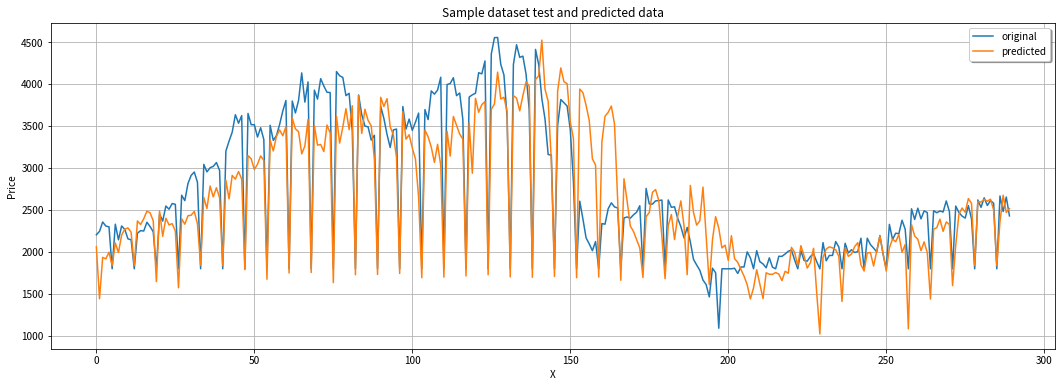

In [16]:
#### evaluation ####
# 0 ~ 36
from sqlalchemy import false

NUM = 2

## model load
tabnet_model = TabNetRegressor(**tabnet_params)
tabnet_model.load_model(f'./model{now}/tabnet-{NUM}-1000-15.zip')

df = pd.read_csv(f'./data/train/train_{NUM}.csv')

for j in df.columns:
	df[j] = df[j].replace({' ': np.nan})

# 사용할 열 선택 및 index 설정
df.drop(tr_del_list, axis=1, inplace=True)

df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df.drop('datadate', axis=1, inplace=True)

# df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayoftheweek'] = df['datetime'].dt.day_of_week

df.drop(cat_del, axis=1, inplace=True)

df.set_index('datetime', drop=True, inplace=True)

# df.set_index('datadate', drop=True, inplace=True)

# nan 처리
df = df.fillna(0)

# to categorical type
# for NUM_i in range(1,3):
#     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

for i_ca in enumerate(cat_features) :
	ca = i_ca[1]
	df[ca] = df[ca].astype("category")

# 변수와 타겟 분리
# x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
x, y = df, df['해당일자_전체평균가격(원)']

# type 변경
x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

# 4주 입력을 통한 이후 4주 예측을 위해 y의 첫 21일을 제외
y = y[14:]
y = y.replace(0, y.mean())

# y의 길이와 같은 길이로 설정
xdata = x[:len(y)]
ydata = pd.Series.to_frame(y)

x_train, x_val, y_train, y_val = train_test_split(xdata.values, ydata.values, test_size=0.2, shuffle=False, random_state=1215)


# mse check
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_pred = tabnet_model.predict(x_val)
# y_val = y_val.fillna(0)

mse_ = mean_squared_error(y_val, y_pred)
rmse_ = mse_**(0.5)
print("mse: %.2f" % mse_)
print("rmse: %.2f" % rmse_)

x_ax = range(len(y_val))
plt.figure(figsize=(18, 6))
plt.plot(x_ax, y_val, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Sample dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()


In [10]:
# lgbm baseline (4w+day)

for i in tqdm(data_list):
    df_number = i.split("_")[-1].split(".")[0]
    df = pd.read_csv(i)

    for j in df.columns:
        df[j] = df[j].replace({' ': np.nan})

    # 사용할 열 선택 및 index 설정
    df.drop(tr_del_list, axis=1, inplace=True)

    df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
    df.drop('datadate', axis=1, inplace=True)

    # df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['dayoftheweek'] = df['datetime'].dt.day_of_week
    
    df.drop(cat_del, axis=1, inplace=True)

    df.set_index('datetime', drop=True, inplace=True)

    # df.set_index('datadate', drop=True, inplace=True)

    # nan 처리
    df = df.fillna(0)

    # to categorical type
    # for NUM_i in range(1,3):
    #     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

    for i_ca in enumerate(cat_features) :
        ca = i_ca[1]
        df[ca] = df[ca].astype("category")

    # 변수와 타겟 분리
    # x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
    x, y = df, df['해당일자_전체평균가격(원)']

    # type 변경
    x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

    # 4주 입력을 통한 이후 4주 예측을 위해 y의 첫 21일을 제외
    y = y[21:]
    y = y.replace(0, y.mean())

    # y의 길이와 같은 길이로 설정
    xdata = x[:len(y)]
    ydata = pd.Series.to_frame(y)

    X_train, X_val, y_train, y_val = train_test_split(xdata.values, ydata.values, test_size=0.2, shuffle=False, random_state=1215)

    # tabnet_model = TabNetRegressor(**tabnet_params)

    # tabnet_model.fit(X_train=x_train,
    #                 y_train=y_train,
    #                 eval_set=[(x_val, y_val)],
    #                 eval_name = ["val"],
    #                 eval_metric = ["rmse"],
    #                 max_epochs=epoch,
    #                 patience=10, batch_size=64, virtual_batch_size=16,
    #                 num_workers=1, drop_last=False,
    #                 # use binary cross entropy as this is not a regression problem
    #                 loss_fn=torch.nn.functional.binary_cross_entropy_with_logits) #loss_fn=torch.nn.functional.binary_cross_entropy_with_logits)
    
    clf = TabNetRegressor(**tabnet_params)
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
        max_epochs=200,
        patience=20,
        batch_size=128*2, virtual_batch_size=16*2,
        num_workers=0,
        drop_last=False,
        # augmentations=aug, #aug
    )

    # 모델 저장
    clf.save_model(f'./model{now}/tabnet_4w-{df_number}-{epoch}-{batch}')

  0%|          | 0/37 [00:00<?, ?it/s]

Device used : cuda
epoch 0  | loss: 4360893.88889| train_rmsle: 40.12358| train_mae: 1900.38576| train_rmse: 2084.9633| train_mse: 4347071.94193| valid_rmsle: 36.735  | valid_mae: 2275.67669| valid_rmse: 2732.51223| valid_mse: 7466623.09241|  0:00:00s
epoch 10 | loss: 4176339.72222| train_rmsle: 10.37686| train_mae: 1804.31696| train_rmse: 1992.14585| train_mse: 3968645.10163| valid_rmsle: 10.51955| valid_mae: 2171.04972| valid_rmse: 2641.5593| valid_mse: 6977835.51107|  0:00:03s
epoch 20 | loss: 3676118.11111| train_rmsle: 5.17291 | train_mae: 1634.20637| train_rmse: 1828.18484| train_mse: 3342259.79407| valid_rmsle: 5.00341 | valid_mae: 1981.24948| valid_rmse: 2476.12294| valid_mse: 6131184.81774|  0:00:07s
epoch 30 | loss: 2874105.38889| train_rmsle: 2.63574 | train_mae: 1376.25208| train_rmse: 1575.27445| train_mse: 2481489.58823| valid_rmsle: 2.79822 | valid_mae: 1720.45793| valid_rmse: 2237.99452| valid_mse: 5008619.48599|  0:00:10s
epoch 40 | loss: 2048925.22222| train_rmsle: 1.

  3%|▎         | 1/37 [00:33<20:16, 33.78s/it]


Early stopping occurred at epoch 101 with best_epoch = 81 and best_valid_mse = 2153211.73334
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-7-1000-15.zip
Device used : cuda
epoch 0  | loss: 370821.15278| train_rmsle: 24.80673| train_mae: 533.55001| train_rmse: 603.35209| train_mse: 364033.74802| valid_rmsle: 22.71817| valid_mae: 512.72689| valid_rmse: 547.29589| valid_mse: 299532.79627|  0:00:00s
epoch 10 | loss: 317089.44444| train_rmsle: 3.54453 | train_mae: 424.04041| train_rmse: 509.66991| train_mse: 259763.4123| valid_rmsle: 3.09001 | valid_mae: 392.35011| valid_rmse: 432.43704| valid_mse: 187001.79002|  0:00:03s
epoch 20 | loss: 202001.03472| train_rmsle: 3.97574 | train_mae: 327.67555| train_rmse: 418.50131| train_mse: 175143.34645| valid_rmsle: 5.5386  | valid_mae: 354.89537| valid_rmse: 400.87332| valid_mse: 160699.4217|  0:00:06s
epoch 30 | loss: 91961.87847| train_rmsle: 0.90299 | train_mae: 157.34775| train_rmse: 

  5%|▌         | 2/37 [00:54<15:17, 26.21s/it]


Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_mse = 24134.65704
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-28-1000-15.zip
Device used : cuda
epoch 0  | loss: 2645858.38889| train_rmsle: 30.33345| train_mae: 1587.74207| train_rmse: 1612.57091| train_mse: 2600384.95055| valid_rmsle: 29.21869| valid_mae: 1581.63049| valid_rmse: 1604.52116| valid_mse: 2574488.14351|  0:00:00s
epoch 10 | loss: 2497779.94444| train_rmsle: 12.20307| train_mae: 1542.66466| train_rmse: 1568.13561| train_mse: 2459049.27803| valid_rmsle: 12.54402| valid_mae: 1538.81624| valid_rmse: 1562.39293| valid_mse: 2441071.65508|  0:00:03s
epoch 20 | loss: 2129140.59722| train_rmsle: 5.68813 | train_mae: 1427.46389| train_rmse: 1452.40325| train_mse: 2109475.20485| valid_rmsle: 5.52509 | valid_mae: 1415.12396| valid_rmse: 1439.62472| valid_mse: 2072519.34764|  0:00:06s
epoch 30 | loss: 1507169.25| train_rmsle: 2.19436 | train_mae: 119

  8%|▊         | 3/37 [01:20<14:46, 26.08s/it]


Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_mse = 46246.21843
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-10-1000-15.zip
Device used : cuda
epoch 0  | loss: 13290827.44444| train_rmsle: 36.43138| train_mae: 3356.6645| train_rmse: 3633.72371| train_mse: 13203948.00758| valid_rmsle: 35.46449| valid_mae: 3452.64364| valid_rmse: 3754.7054| valid_mse: 14097812.65239|  0:00:00s
epoch 10 | loss: 12941346.44444| train_rmsle: 25.91308| train_mae: 3295.95401| train_rmse: 3566.41177| train_mse: 12719292.91378| valid_rmsle: 29.9742 | valid_mae: 3407.36242| valid_rmse: 3700.60975| valid_mse: 13694512.52311|  0:00:03s
epoch 20 | loss: 12040166.66667| train_rmsle: 26.04397| train_mae: 3206.83318| train_rmse: 3449.22266| train_mse: 11897136.94308| valid_rmsle: 29.07538| valid_mae: 3343.53044| valid_rmse: 3615.1477| valid_mse: 13069292.85966|  0:00:06s
epoch 30 | loss: 10624464.66667| train_rmsle: 14.84112| trai

 11%|█         | 4/37 [02:05<18:28, 33.58s/it]


Early stopping occurred at epoch 121 with best_epoch = 101 and best_valid_mse = 1626085.24088
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-34-1000-15.zip
Device used : cuda
epoch 0  | loss: 14431438.0| train_rmsle: 45.42018| train_mae: 3701.50669| train_rmse: 3793.52042| train_mse: 14390797.16496| valid_rmsle: 42.68234| valid_mae: 3866.93339| valid_rmse: 4058.5925| valid_mse: 16472173.10841|  0:00:00s
epoch 10 | loss: 14067699.55556| train_rmsle: 18.67733| train_mae: 3631.21274| train_rmse: 3717.85402| train_mse: 13822438.51481| valid_rmsle: 21.71733| valid_mae: 3824.51485| valid_rmse: 4017.85932| valid_mse: 16143193.54204|  0:00:04s
epoch 20 | loss: 13065266.44444| train_rmsle: 11.88622| train_mae: 3460.90691| train_rmse: 3542.20292| train_mse: 12547201.49959| valid_rmsle: 15.20005| valid_mae: 3715.49931| valid_rmse: 3894.79101| valid_mse: 15169396.97629|  0:00:08s
epoch 30 | loss: 11452711.22222| train_rmsle: 6.22121 | tr

 14%|█▎        | 5/37 [03:07<23:23, 43.85s/it]


Early stopping occurred at epoch 179 with best_epoch = 159 and best_valid_mse = 464321.31058
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-32-1000-15.zip
Device used : cuda
epoch 0  | loss: 15200526.88889| train_rmsle: 42.25188| train_mae: 3557.66158| train_rmse: 3895.64522| train_mse: 15176051.64837| valid_rmsle: 44.82356| valid_mae: 4177.47613| valid_rmse: 4605.32239| valid_mse: 21208994.29381|  0:00:00s
epoch 10 | loss: 14773710.0| train_rmsle: 22.19017| train_mae: 3460.08721| train_rmse: 3783.55847| train_mse: 14315314.73261| valid_rmsle: 19.03299| valid_mae: 4062.37058| valid_rmse: 4479.67246| valid_mse: 20067465.34127|  0:00:03s
epoch 20 | loss: 13626404.11111| train_rmsle: 14.33564| train_mae: 3344.73506| train_rmse: 3637.39718| train_mse: 13230658.24145| valid_rmsle: 11.88644| valid_mae: 3914.62993| valid_rmse: 4297.90659| valid_mse: 18472001.09285|  0:00:06s
epoch 30 | loss: 11600479.88889| train_rmsle: 10.14922| tr

 16%|█▌        | 6/37 [03:56<23:25, 45.35s/it]


Early stopping occurred at epoch 151 with best_epoch = 131 and best_valid_mse = 551822.5005
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-11-1000-15.zip
Device used : cuda
epoch 0  | loss: 30885482.88889| train_rmsle: 44.60236| train_mae: 5204.03238| train_rmse: 5549.49377| train_mse: 30796881.07727| valid_rmsle: 45.46613| valid_mae: 5696.82793| valid_rmse: 6119.00171| valid_mse: 37442181.88201|  0:00:00s
epoch 10 | loss: 30368615.11111| train_rmsle: 14.41612| train_mae: 5064.06383| train_rmse: 5423.29198| train_mse: 29412095.90627| valid_rmsle: 13.65887| valid_mae: 5534.08 | valid_rmse: 5964.71803| valid_mse: 35577861.20334|  0:00:03s
epoch 20 | loss: 28919367.77778| train_rmsle: 8.15877 | train_mae: 4895.64749| train_rmse: 5250.26839| train_mse: 27565318.21743| valid_rmsle: 8.22205 | valid_mae: 5376.64868| valid_rmse: 5813.0704| valid_mse: 33791787.44187|  0:00:06s
epoch 30 | loss: 26446014.44444| train_rmsle: 5.7783  | tr

 19%|█▉        | 7/37 [04:42<22:49, 45.65s/it]


Early stopping occurred at epoch 144 with best_epoch = 124 and best_valid_mse = 4313725.26067
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-27-1000-15.zip
Device used : cuda
epoch 0  | loss: 5332157.27778| train_rmsle: 45.65031| train_mae: 2229.66117| train_rmse: 2306.0441| train_mse: 5317839.39947| valid_rmsle: 44.02509| valid_mae: 2138.67937| valid_rmse: 2214.40613| valid_mse: 4903594.5135|  0:00:00s
epoch 10 | loss: 5122326.33333| train_rmsle: 12.75345| train_mae: 2160.07977| train_rmse: 2237.90054| train_mse: 5008198.82515| valid_rmsle: 11.8025 | valid_mae: 2064.05704| valid_rmse: 2142.43512| valid_mse: 4590028.23882|  0:00:03s
epoch 20 | loss: 4581692.27778| train_rmsle: 5.7944  | train_mae: 2017.75965| train_rmse: 2096.89033| train_mse: 4396949.05016| valid_rmsle: 5.24929 | valid_mae: 1909.43252| valid_rmse: 1993.75428| valid_mse: 3975056.11886|  0:00:06s
epoch 30 | loss: 3673337.55556| train_rmsle: 2.57646 | train_mae

 22%|██▏       | 8/37 [05:20<20:58, 43.41s/it]

epoch 120| loss: 102438.66493| train_rmsle: 0.01133 | train_mae: 179.67048| train_rmse: 278.72507| train_mse: 77687.66242| valid_rmsle: 0.04204 | valid_mae: 349.10711| valid_rmse: 513.03854| valid_mse: 263208.5386|  0:00:38s

Early stopping occurred at epoch 120 with best_epoch = 100 and best_valid_mse = 254042.29587
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-35-1000-15.zip
Device used : cuda
epoch 0  | loss: 3239545.0| train_rmsle: 33.84541| train_mae: 1696.71947| train_rmse: 1791.9249| train_mse: 3210994.84099| valid_rmsle: 28.47846| valid_mae: 1504.5258| valid_rmse: 1548.15127| valid_mse: 2396772.34035|  0:00:00s
epoch 10 | loss: 3066390.55556| train_rmsle: 7.6213  | train_mae: 1560.13406| train_rmse: 1653.42992| train_mse: 2733830.4915| valid_rmsle: 8.65529 | valid_mae: 1388.91969| valid_rmse: 1437.76397| valid_mse: 2067165.24019|  0:00:03s
epoch 20 | loss: 2668605.27778| train_rmsle: 3.19166 | train_mae: 1333.55025| t

 24%|██▍       | 9/37 [06:00<19:39, 42.13s/it]


Early stopping occurred at epoch 123 with best_epoch = 103 and best_valid_mse = 182247.05432
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-36-1000-15.zip
Device used : cuda
epoch 0  | loss: 43356592.44444| train_rmsle: 52.26653| train_mae: 4455.58017| train_rmse: 6582.40899| train_mse: 43328108.10527| valid_rmsle: 49.21354| valid_mae: 5149.57684| valid_rmse: 8089.55358| valid_mse: 65440877.18704|  0:00:00s
epoch 10 | loss: 42765382.66667| train_rmsle: 27.50079| train_mae: 4398.24839| train_rmse: 6523.91327| train_mse: 42561444.3578| valid_rmsle: 34.33477| valid_mae: 5131.0127| valid_rmse: 8073.28779| valid_mse: 65177975.69423|  0:00:03s
epoch 20 | loss: 41465120.88889| train_rmsle: 21.78464| train_mae: 4315.88086| train_rmse: 6433.49069| train_mse: 41389802.46764| valid_rmsle: 26.62249| valid_mae: 5069.79803| valid_rmse: 8016.61511| valid_mse: 64266117.83272|  0:00:06s
epoch 30 | loss: 39355981.33333| train_rmsle: 12.78782| 

 27%|██▋       | 10/37 [06:41<18:46, 41.73s/it]


Early stopping occurred at epoch 128 with best_epoch = 108 and best_valid_mse = 49368588.46508
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-6-1000-15.zip
Device used : cuda
epoch 0  | loss: 90793172.44444| train_rmsle: 58.56096| train_mae: 8020.76266| train_rmse: 9526.25228| train_mse: 90749482.57551| valid_rmsle: 66.20034| valid_mae: 11296.64698| valid_rmse: 13884.14194| valid_mse: 192769397.45804|  0:00:00s
epoch 10 | loss: 89857036.44444| train_rmsle: 36.69189| train_mae: 7977.54807| train_rmse: 9468.64942| train_mse: 89655321.91494| valid_rmsle: 35.87538| valid_mae: 11217.34567| valid_rmse: 13798.8201| valid_mse: 190407436.17841|  0:00:03s
epoch 20 | loss: 87208950.22222| train_rmsle: 18.56532| train_mae: 7843.49828| train_rmse: 9322.27539| train_mse: 86904818.46025| valid_rmsle: 19.27046| valid_mae: 11073.74378| valid_rmse: 13651.17255| valid_mse: 186354512.04776|  0:00:06s
epoch 30 | loss: 82321295.11111| train_rmsle:

 30%|██▉       | 11/37 [07:44<20:56, 48.34s/it]

Stop training because you reached max_epochs = 200 with best_epoch = 195 and best_valid_mse = 65722927.64079
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-18-1000-15.zip
Device used : cuda
epoch 0  | loss: 12596406.66667| train_rmsle: 38.61723| train_mae: 3475.745| train_rmse: 3537.96045| train_mse: 12517164.11494| valid_rmsle: 44.93772| valid_mae: 4448.59196| valid_rmse: 4550.06371| valid_mse: 20703079.76489|  0:00:00s
epoch 10 | loss: 12256689.88889| train_rmsle: 16.79781| train_mae: 3415.93983| train_rmse: 3479.58877| train_mse: 12107537.9821| valid_rmsle: 17.99801| valid_mae: 4383.99273| valid_rmse: 4486.67619| valid_mse: 20130263.24154|  0:00:03s
epoch 20 | loss: 11395851.22222| train_rmsle: 8.78825 | train_mae: 3266.19863| train_rmse: 3327.05937| train_mse: 11069324.06588| valid_rmsle: 8.56309 | valid_mae: 4203.95774| valid_rmse: 4307.52232| valid_mse: 18554748.54367|  0:00:06s
epoch 30 | loss: 9926757.0| train_rmsle: 4

 32%|███▏      | 12/37 [08:22<18:49, 45.18s/it]


Early stopping occurred at epoch 118 with best_epoch = 98 and best_valid_mse = 979029.09719
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-8-1000-15.zip
Device used : cuda
epoch 0  | loss: 17913251.11111| train_rmsle: 55.12256| train_mae: 4120.50965| train_rmse: 4231.8329| train_mse: 17908409.70782| valid_rmsle: 52.9837 | valid_mae: 5290.12254| valid_rmse: 5457.8433| valid_mse: 29788053.53308|  0:00:00s
epoch 10 | loss: 17503325.55556| train_rmsle: 22.69596| train_mae: 4058.79049| train_rmse: 4166.24001| train_mse: 17357555.82897| valid_rmsle: 23.53453| valid_mae: 5232.82729| valid_rmse: 5398.43946| valid_mse: 29143148.57881|  0:00:03s
epoch 20 | loss: 16441680.0| train_rmsle: 11.27557| train_mae: 3930.96733| train_rmse: 4030.80811| train_mse: 16247414.05798| valid_rmsle: 12.63504| valid_mae: 5115.14245| valid_rmse: 5279.13223| valid_mse: 27869237.12623|  0:00:06s
epoch 30 | loss: 14581532.44444| train_rmsle: 6.46398 | train_

 35%|███▌      | 13/37 [09:09<18:20, 45.87s/it]


Early stopping occurred at epoch 148 with best_epoch = 128 and best_valid_mse = 1267027.23402
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-5-1000-15.zip
Device used : cuda
epoch 0  | loss: 352403.25| train_rmsle: 23.98137| train_mae: 542.3504| train_rmse: 587.50517| train_mse: 345162.32231| valid_rmsle: 24.97504| valid_mae: 749.83797| valid_rmse: 828.02061| valid_mse: 685618.13285|  0:00:00s
epoch 10 | loss: 297243.70139| train_rmsle: 3.57931 | train_mae: 429.35268| train_rmse: 482.81896| train_mse: 233114.14699| valid_rmsle: 3.70457 | valid_mae: 612.60181| valid_rmse: 715.76748| valid_mse: 512323.08056|  0:00:03s
epoch 20 | loss: 170018.73264| train_rmsle: 1.47145 | train_mae: 291.68091| train_rmse: 336.30663| train_mse: 113102.15202| valid_rmsle: 1.1171  | valid_mae: 460.84125| valid_rmse: 568.66855| valid_mse: 323383.92318|  0:00:06s
epoch 30 | loss: 50817.81011| train_rmsle: 0.25695 | train_mae: 143.85587| train_rmse: 1

 38%|███▊      | 14/37 [09:36<15:23, 40.14s/it]


Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_mse = 112811.43224
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-22-1000-15.zip
Device used : cuda
epoch 0  | loss: 2403775.61111| train_rmsle: 38.78853| train_mae: 1463.24793| train_rmse: 1547.36597| train_mse: 2394341.44358| valid_rmsle: 38.97483| valid_mae: 1518.84044| valid_rmse: 1623.22299| valid_mse: 2634852.8867|  0:00:00s
epoch 10 | loss: 2254117.88889| train_rmsle: 12.69078| train_mae: 1407.78274| train_rmse: 1488.70803| train_mse: 2216251.59649| valid_rmsle: 13.51472| valid_mae: 1475.51161| valid_rmse: 1580.57092| valid_mse: 2498204.43051|  0:00:03s
epoch 20 | loss: 1869674.79167| train_rmsle: 5.39257 | train_mae: 1282.93836| train_rmse: 1358.56245| train_mse: 1845691.92608| valid_rmsle: 6.68451 | valid_mae: 1378.70421| valid_rmse: 1489.89397| valid_mse: 2219784.03869|  0:00:06s
epoch 30 | loss: 1261623.05556| train_rmsle: 1.67009 | train_mae: 

 41%|████      | 15/37 [10:07<13:38, 37.19s/it]


Early stopping occurred at epoch 91 with best_epoch = 71 and best_valid_mse = 282152.32321
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-20-1000-15.zip
Device used : cuda
epoch 0  | loss: 10861895.33333| train_rmsle: 50.62707| train_mae: 2904.92025| train_rmse: 3294.39307| train_mse: 10853025.72334| valid_rmsle: 45.51476| valid_mae: 2737.97031| valid_rmse: 2996.51227| valid_mse: 8979085.75443|  0:00:00s
epoch 10 | loss: 10524000.66667| train_rmsle: 25.93059| train_mae: 2875.65418| train_rmse: 3258.80689| train_mse: 10619822.3256| valid_rmsle: 27.8392 | valid_mae: 2702.96359| valid_rmse: 2964.2972| valid_mse: 8787057.86369|  0:00:03s
epoch 20 | loss: 9677233.77778| train_rmsle: 17.04778| train_mae: 2764.32692| train_rmse: 3118.57071| train_mse: 9725483.26397| valid_rmsle: 21.6804 | valid_mae: 2639.78903| valid_rmse: 2878.88494| valid_mse: 8287978.47406|  0:00:06s
epoch 30 | loss: 8127426.88889| train_rmsle: 10.39042| train_ma

 43%|████▎     | 16/37 [10:51<13:46, 39.34s/it]


Early stopping occurred at epoch 138 with best_epoch = 118 and best_valid_mse = 1402034.23886
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-16-1000-15.zip
Device used : cuda
epoch 0  | loss: 2143550.91667| train_rmsle: 39.18887| train_mae: 1325.87162| train_rmse: 1464.46136| train_mse: 2144647.0727| valid_rmsle: 35.04728| valid_mae: 1090.00997| valid_rmse: 1111.17344| valid_mse: 1234706.40827|  0:00:00s
epoch 10 | loss: 1999908.86111| train_rmsle: 14.04371| train_mae: 1243.69847| train_rmse: 1374.12847| train_mse: 1888229.05585| valid_rmsle: 16.34303| valid_mae: 1041.53185| valid_rmse: 1059.9375| valid_mse: 1123467.49941|  0:00:03s
epoch 20 | loss: 1607342.97222| train_rmsle: 5.7304  | train_mae: 1065.6943| train_rmse: 1158.88941| train_mse: 1343024.65556| valid_rmsle: 9.01197 | valid_mae: 959.75592| valid_rmse: 976.39399| valid_mse: 953345.21977|  0:00:06s
epoch 30 | loss: 1025481.15278| train_rmsle: 2.48947 | train_mae: 84

 46%|████▌     | 17/37 [11:21<12:12, 36.62s/it]


Early stopping occurred at epoch 92 with best_epoch = 72 and best_valid_mse = 57424.27697
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-1-1000-15.zip
Device used : cuda
epoch 0  | loss: 3893433.19444| train_rmsle: 43.61846| train_mae: 1919.1177| train_rmse: 1970.46307| train_mse: 3882724.71303| valid_rmsle: 42.52625| valid_mae: 2698.19587| valid_rmse: 2820.21383| valid_mse: 7953606.05263|  0:00:00s
epoch 10 | loss: 3707441.83333| train_rmsle: 10.25346| train_mae: 1809.32886| train_rmse: 1856.29157| train_mse: 3445818.39838| valid_rmsle: 11.48271| valid_mae: 2556.51852| valid_rmse: 2671.90442| valid_mse: 7139073.22559|  0:00:03s
epoch 20 | loss: 3210760.94444| train_rmsle: 4.98922 | train_mae: 1651.2587| train_rmse: 1691.3668| train_mse: 2860721.64297| valid_rmsle: 4.77929 | valid_mae: 2333.11155| valid_rmse: 2451.92462| valid_mse: 6011934.35893|  0:00:06s
epoch 30 | loss: 2431467.44444| train_rmsle: 1.91205 | train_mae: 1384

 49%|████▊     | 18/37 [11:51<10:56, 34.55s/it]


Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_mse = 274804.2195
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-2-1000-15.zip
Device used : cuda
epoch 0  | loss: 556700.89583| train_rmsle: 24.68074| train_mae: 698.97689| train_rmse: 739.44474| train_mse: 546778.52197| valid_rmsle: 28.74725| valid_mae: 856.80171| valid_rmse: 884.31797| valid_mse: 782018.26569|  0:00:00s
epoch 10 | loss: 484902.57986| train_rmsle: 5.43703 | train_mae: 614.92499| train_rmse: 652.52883| train_mse: 425793.87539| valid_rmsle: 6.42378 | valid_mae: 770.74595| valid_rmse: 796.25418| valid_mse: 634020.7239|  0:00:03s
epoch 20 | loss: 316187.24653| train_rmsle: 1.56334 | train_mae: 425.43698| train_rmse: 455.85463| train_mse: 207803.43975| valid_rmsle: 1.01144 | valid_mae: 529.02285| valid_rmse: 559.46103| valid_mse: 312996.6422|  0:00:06s
epoch 30 | loss: 118296.4809| train_rmsle: 0.68919 | train_mae: 260.36669| train_rmse: 294

 51%|█████▏    | 19/37 [12:17<09:33, 31.87s/it]


Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_mse = 29940.09234
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-30-1000-15.zip
Device used : cuda
epoch 0  | loss: 428057.41667| train_rmsle: 20.23303| train_mae: 590.63569| train_rmse: 645.95193| train_mse: 417253.8907| valid_rmsle: 23.34176| valid_mae: 807.15496| valid_rmse: 911.43046| valid_mse: 830705.48676|  0:00:00s
epoch 10 | loss: 366418.19444| train_rmsle: 4.50356 | train_mae: 492.64538| train_rmse: 542.80455| train_mse: 294636.77754| valid_rmsle: 3.86593 | valid_mae: 661.01729| valid_rmse: 766.13008| valid_mse: 586955.29191|  0:00:03s
epoch 20 | loss: 225396.75694| train_rmsle: 2.64765 | train_mae: 390.30533| train_rmse: 431.70105| train_mse: 186365.79273| valid_rmsle: 2.32958 | valid_mae: 533.32455| valid_rmse: 639.90417| valid_mse: 409477.35079|  0:00:06s
epoch 30 | loss: 74562.45573| train_rmsle: 0.2794  | train_mae: 173.52972| train_rmse: 2

 54%|█████▍    | 20/37 [12:36<07:58, 28.13s/it]

epoch 60 | loss: 15959.37435| train_rmsle: 0.02195 | train_mae: 65.25654| train_rmse: 112.15364| train_mse: 12578.43801| valid_rmsle: 0.17664 | valid_mae: 269.12066| valid_rmse: 425.05199| valid_mse: 180669.19023|  0:00:19s

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_mse = 142975.90375
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-21-1000-15.zip
Device used : cuda
epoch 0  | loss: 6212887.77778| train_rmsle: 45.73525| train_mae: 2414.8413| train_rmse: 2490.36097| train_mse: 6201897.77686| valid_rmsle: 48.1745 | valid_mae: 2438.50616| valid_rmse: 2473.97499| valid_mse: 6120552.2597|  0:00:00s
epoch 10 | loss: 5983161.16667| train_rmsle: 15.45139| train_mae: 2356.77563| train_rmse: 2430.48735| train_mse: 5907268.76374| valid_rmsle: 16.41578| valid_mae: 2387.57764| valid_rmse: 2422.61741| valid_mse: 5869075.13044|  0:00:03s
epoch 20 | loss: 5371710.77778| train_rmsle: 7.37599 | train_mae: 2222.96747|

 57%|█████▋    | 21/37 [13:08<07:48, 29.29s/it]


Early stopping occurred at epoch 99 with best_epoch = 79 and best_valid_mse = 145894.07995
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-13-1000-15.zip
Device used : cuda
epoch 0  | loss: 2416267.55556| train_rmsle: 31.56646| train_mae: 1528.18288| train_rmse: 1544.39774| train_mse: 2385164.38948| valid_rmsle: 29.5893 | valid_mae: 1551.4504| valid_rmse: 1576.58912| valid_mse: 2485633.26364|  0:00:00s
epoch 10 | loss: 2271937.61111| train_rmsle: 13.34061| train_mae: 1493.27963| train_rmse: 1509.50954| train_mse: 2278619.03958| valid_rmsle: 13.24784| valid_mae: 1519.85959| valid_rmse: 1545.59832| valid_mse: 2388874.16787|  0:00:03s
epoch 20 | loss: 1951763.91667| train_rmsle: 5.40571 | train_mae: 1377.58819| train_rmse: 1394.16609| train_mse: 1943699.09726| valid_rmsle: 5.48116 | valid_mae: 1405.25709| valid_rmse: 1432.40246| valid_mse: 2051776.81671|  0:00:06s
epoch 30 | loss: 1438836.20833| train_rmsle: 2.16053 | train_mae: 

 59%|█████▉    | 22/37 [13:41<07:35, 30.36s/it]


Early stopping occurred at epoch 102 with best_epoch = 82 and best_valid_mse = 35424.09855
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-9-1000-15.zip
Device used : cuda
epoch 0  | loss: 1022942.54167| train_rmsle: 24.32225| train_mae: 940.84995| train_rmse: 1002.63916| train_mse: 1005285.28748| valid_rmsle: 22.7357 | valid_mae: 988.59857| valid_rmse: 1077.13614| valid_mse: 1160222.27017|  0:00:00s
epoch 10 | loss: 931946.78472| train_rmsle: 6.47282 | train_mae: 842.01733| train_rmse: 907.01697| train_mse: 822679.77596| valid_rmsle: 5.93503 | valid_mae: 889.11612| valid_rmse: 979.58194| valid_mse: 959580.78653|  0:00:03s
epoch 20 | loss: 710737.55556| train_rmsle: 2.55291 | train_mae: 728.34538| train_rmse: 792.76882| train_mse: 628482.4022| valid_rmsle: 2.73407 | valid_mae: 788.07293| valid_rmse: 890.29278| valid_mse: 792621.23199|  0:00:06s
epoch 30 | loss: 390801.47917| train_rmsle: 0.61563 | train_mae: 491.43805| train_r

 62%|██████▏   | 23/37 [14:04<06:33, 28.08s/it]

epoch 70 | loss: 44543.34462| train_rmsle: 0.03433 | train_mae: 131.81468| train_rmse: 187.23382| train_mse: 35056.50494| valid_rmsle: 0.1335  | valid_mae: 289.02894| valid_rmse: 423.88981| valid_mse: 179682.56922|  0:00:22s

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_mse = 145362.7539
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-24-1000-15.zip
Device used : cuda
epoch 0  | loss: 12165540.77778| train_rmsle: 44.73285| train_mae: 3185.1499| train_rmse: 3483.07799| train_mse: 12131832.30958| valid_rmsle: 45.77097| valid_mae: 4307.12688| valid_rmse: 4486.00728| valid_mse: 20124261.31745|  0:00:00s
epoch 10 | loss: 11867330.55556| train_rmsle: 16.79135| train_mae: 3128.8834| train_rmse: 3430.45579| train_mse: 11768026.95641| valid_rmsle: 19.09335| valid_mae: 4246.21581| valid_rmse: 4426.82549| valid_mse: 19596783.89207|  0:00:03s
epoch 20 | loss: 11095937.11111| train_rmsle: 9.50592 | train_mae: 3010

 65%|██████▍   | 24/37 [14:49<07:11, 33.22s/it]


Early stopping occurred at epoch 139 with best_epoch = 119 and best_valid_mse = 2430955.65005
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-0-1000-15.zip
Device used : cuda
epoch 0  | loss: 4111713.22222| train_rmsle: 32.31574| train_mae: 1924.36617| train_rmse: 2019.42419| train_mse: 4078074.05817| valid_rmsle: 33.19415| valid_mae: 2387.4421| valid_rmse: 2480.43049| valid_mse: 6152535.43386|  0:00:00s
epoch 10 | loss: 3919491.83333| train_rmsle: 11.45533| train_mae: 1833.05215| train_rmse: 1928.19919| train_mse: 3717952.1036| valid_rmsle: 11.67713| valid_mae: 2281.96866| valid_rmse: 2375.32855| valid_mse: 5642185.70727|  0:00:03s
epoch 20 | loss: 3416076.11111| train_rmsle: 5.21845 | train_mae: 1642.713| train_rmse: 1730.96929| train_mse: 2996254.68516| valid_rmsle: 4.76163 | valid_mae: 2033.01162| valid_rmse: 2124.78831| valid_mse: 4514725.38007|  0:00:06s
epoch 30 | loss: 2585168.77778| train_rmsle: 2.32568 | train_mae: 1

 68%|██████▊   | 25/37 [15:19<06:27, 32.25s/it]


Early stopping occurred at epoch 93 with best_epoch = 73 and best_valid_mse = 270042.82655
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-4-1000-15.zip
Device used : cuda
epoch 0  | loss: 14298741.66667| train_rmsle: 45.74898| train_mae: 3466.38075| train_rmse: 3775.88338| train_mse: 14257295.28325| valid_rmsle: 46.45314| valid_mae: 3277.75358| valid_rmse: 3505.04435| valid_mse: 12285335.92356|  0:00:00s
epoch 10 | loss: 13946991.66667| train_rmsle: 16.13064| train_mae: 3377.50027| train_rmse: 3677.35826| train_mse: 13522963.8057| valid_rmsle: 15.88253| valid_mae: 3206.32986| valid_rmse: 3434.95507| valid_mse: 11798916.35492|  0:00:03s
epoch 20 | loss: 12918608.88889| train_rmsle: 10.29748| train_mae: 3252.17564| train_rmse: 3534.17623| train_mse: 12490401.59568| valid_rmsle: 10.93239| valid_mae: 3110.47601| valid_rmse: 3347.50279| valid_mse: 11205774.9396|  0:00:06s
epoch 30 | loss: 11165327.88889| train_rmsle: 5.02331 | tra

 70%|███████   | 26/37 [15:59<06:19, 34.53s/it]


Early stopping occurred at epoch 124 with best_epoch = 104 and best_valid_mse = 1456264.11401
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-31-1000-15.zip
Device used : cuda
epoch 0  | loss: 58398968.44444| train_rmsle: 62.58624| train_mae: 7377.09828| train_rmse: 7639.12305| train_mse: 58356200.95014| valid_rmsle: 60.81687| valid_mae: 9219.9054| valid_rmse: 9696.26926| valid_mse: 94017637.57352|  0:00:00s
epoch 10 | loss: 57697151.55556| train_rmsle: 22.28076| train_mae: 7295.43257| train_rmse: 7554.52728| train_mse: 57070882.42304| valid_rmsle: 18.5167 | valid_mae: 9083.88044| valid_rmse: 9561.7209| valid_mse: 91426506.66103|  0:00:03s
epoch 20 | loss: 55768326.66667| train_rmsle: 11.98012| train_mae: 7114.85288| train_rmse: 7374.06986| train_mse: 54376906.28625| valid_rmsle: 11.68155| valid_mae: 8889.13111| valid_rmse: 9364.80996| valid_mse: 87699665.52924|  0:00:06s
epoch 30 | loss: 52258767.11111| train_rmsle: 7.79995 |

 73%|███████▎  | 27/37 [16:52<06:40, 40.05s/it]


Early stopping occurred at epoch 166 with best_epoch = 146 and best_valid_mse = 8921610.8602
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-14-1000-15.zip
Device used : cuda
epoch 0  | loss: 10424138.0| train_rmsle: 40.46105| train_mae: 3151.44778| train_rmse: 3219.56124| train_mse: 10365574.60556| valid_rmsle: 36.99916| valid_mae: 2397.27243| valid_rmse: 2441.39015| valid_mse: 5960385.86467|  0:00:00s
epoch 10 | loss: 10114645.33333| train_rmsle: 17.94779| train_mae: 3109.05879| train_rmse: 3177.07752| train_mse: 10093821.59153| valid_rmsle: 15.47499| valid_mae: 2352.07639| valid_rmse: 2397.47896| valid_mse: 5747905.36347|  0:00:03s
epoch 20 | loss: 9331999.55556| train_rmsle: 8.43758 | train_mae: 2967.92238| train_rmse: 3031.40039| train_mse: 9189388.33984| valid_rmsle: 7.14253 | valid_mae: 2226.36734| valid_rmse: 2271.77472| valid_mse: 5160960.38099|  0:00:06s
epoch 30 | loss: 7961826.44444| train_rmsle: 4.59486 | train_ma

 76%|███████▌  | 28/37 [17:25<05:43, 38.21s/it]


Early stopping occurred at epoch 105 with best_epoch = 85 and best_valid_mse = 188497.79011
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-12-1000-15.zip
Device used : cuda
epoch 0  | loss: 1058337.48611| train_rmsle: 30.33951| train_mae: 995.12951| train_rmse: 1018.84225| train_mse: 1038039.53434| valid_rmsle: 30.01864| valid_mae: 1182.11321| valid_rmse: 1227.26678| valid_mse: 1506183.75053|  0:00:00s
epoch 10 | loss: 963687.34722| train_rmsle: 7.6042  | train_mae: 922.72701| train_rmse: 945.33721| train_mse: 893662.44241| valid_rmsle: 6.95677 | valid_mae: 1084.87319| valid_rmse: 1128.95979| valid_mse: 1274550.21012|  0:00:03s
epoch 20 | loss: 732338.41667| train_rmsle: 2.88783 | train_mae: 783.0805| train_rmse: 807.83234| train_mse: 652593.09104| valid_rmsle: 3.08173 | valid_mae: 940.01804| valid_rmse: 986.7208| valid_mse: 973617.93812|  0:00:06s
epoch 30 | loss: 388151.27778| train_rmsle: 0.85947 | train_mae: 555.3803| tra

 78%|███████▊  | 29/37 [17:51<04:36, 34.50s/it]

epoch 80 | loss: 16231.32227| train_rmsle: 0.01067 | train_mae: 74.72558| train_rmse: 109.99814| train_mse: 12099.59098| valid_rmsle: 0.05314 | valid_mae: 202.79193| valid_rmse: 319.65297| valid_mse: 102178.02242|  0:00:25s

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_mse = 95063.3151
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-29-1000-15.zip
Device used : cuda
epoch 0  | loss: 4276897.22222| train_rmsle: 39.46562| train_mae: 2019.90095| train_rmse: 2063.7278| train_mse: 4258972.45134| valid_rmsle: 44.33639| valid_mae: 2860.11763| valid_rmse: 2960.75907| valid_mse: 8766094.28606|  0:00:00s
epoch 10 | loss: 4090330.25| train_rmsle: 12.94227| train_mae: 1961.67627| train_rmse: 2005.81276| train_mse: 4023284.84436| valid_rmsle: 15.86683| valid_mae: 2808.40904| valid_rmse: 2911.11205| valid_mse: 8474573.36701|  0:00:03s
epoch 20 | loss: 3602155.22222| train_rmsle: 5.06759 | train_mae: 1791.95012| tra

 81%|████████  | 30/37 [18:18<03:45, 32.20s/it]


Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_mse = 749129.21277
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-3-1000-15.zip
Device used : cuda
epoch 0  | loss: 7480183.66667| train_rmsle: 46.0672 | train_mae: 2457.93326| train_rmse: 2733.15349| train_mse: 7470127.98865| valid_rmsle: 50.3959 | valid_mae: 2597.10843| valid_rmse: 2954.31122| valid_mse: 8727954.80825|  0:00:00s
epoch 10 | loss: 7218327.94444| train_rmsle: 10.5929 | train_mae: 2314.00969| train_rmse: 2593.6659| train_mse: 6727102.78122| valid_rmsle: 10.9943 | valid_mae: 2444.1444| valid_rmse: 2806.13713| valid_mse: 7874405.58801|  0:00:03s
epoch 20 | loss: 6463445.44444| train_rmsle: 10.02905| train_mae: 2202.23104| train_rmse: 2451.95633| train_mse: 6012089.83172| valid_rmsle: 10.53257| valid_mae: 2338.97138| valid_rmse: 2677.97783| valid_mse: 7171565.25269|  0:00:06s
epoch 30 | loss: 5266573.66667| train_rmsle: 7.87247 | train_mae: 19

 84%|████████▍ | 31/37 [19:16<03:59, 39.91s/it]


Early stopping occurred at epoch 181 with best_epoch = 161 and best_valid_mse = 1052320.52146
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-26-1000-15.zip
Device used : cuda
epoch 0  | loss: 8779718.66667| train_rmsle: 37.37476| train_mae: 2498.57811| train_rmse: 2955.18986| train_mse: 8733147.08109| valid_rmsle: 40.15314| valid_mae: 3112.25646| valid_rmse: 3620.38155| valid_mse: 13107162.56542|  0:00:00s
epoch 10 | loss: 8467498.22222| train_rmsle: 15.90756| train_mae: 2372.84628| train_rmse: 2799.32551| train_mse: 7836223.31784| valid_rmsle: 13.12951| valid_mae: 2978.53466| valid_rmse: 3485.88984| valid_mse: 12151427.97533|  0:00:03s
epoch 20 | loss: 7818241.94444| train_rmsle: 11.25448| train_mae: 2294.53894| train_rmse: 2683.40655| train_mse: 7200670.72741| valid_rmsle: 9.5341  | valid_mae: 2947.72956| valid_rmse: 3481.17993| valid_mse: 12118613.70983|  0:00:06s


 86%|████████▋ | 32/37 [19:23<02:30, 30.15s/it]


Early stopping occurred at epoch 22 with best_epoch = 2 and best_valid_mse = 11192730.20008
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-25-1000-15.zip
Device used : cuda
epoch 0  | loss: 3428624.22222| train_rmsle: 40.77218| train_mae: 1735.24339| train_rmse: 1847.05511| train_mse: 3411612.59214| valid_rmsle: 37.49738| valid_mae: 1610.27332| valid_rmse: 1703.39719| valid_mse: 2901561.97535|  0:00:00s
epoch 10 | loss: 3249348.22222| train_rmsle: 14.70153| train_mae: 1682.46247| train_rmse: 1790.09745| train_mse: 3204448.87288| valid_rmsle: 13.80014| valid_mae: 1561.71494| valid_rmse: 1652.74626| valid_mse: 2731570.18531|  0:00:03s
epoch 20 | loss: 2786996.38889| train_rmsle: 5.86285 | train_mae: 1523.69743| train_rmse: 1626.09911| train_mse: 2644198.32117| valid_rmsle: 4.65986 | valid_mae: 1395.29262| valid_rmse: 1498.3042| valid_mse: 2244915.4699|  0:00:06s
epoch 30 | loss: 2036997.41667| train_rmsle: 2.52715 | train_mae: 

 89%|████████▉ | 33/37 [19:46<01:52, 28.00s/it]

epoch 70 | loss: 115389.70399| train_rmsle: 0.0291  | train_mae: 209.33007| train_rmse: 291.17448| train_mse: 84782.57612| valid_rmsle: 0.25715 | valid_mae: 781.03255| valid_rmse: 953.98272| valid_mse: 910083.02702|  0:00:22s

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_mse = 421554.12011
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-19-1000-15.zip
Device used : cuda
epoch 0  | loss: 14133250.66667| train_rmsle: 41.25582| train_mae: 3079.24537| train_rmse: 3754.92582| train_mse: 14099467.90322| valid_rmsle: 41.61276| valid_mae: 3312.47952| valid_rmse: 4093.5  | valid_mse: 16756742.23273|  0:00:00s
epoch 10 | loss: 13758706.44444| train_rmsle: 15.43911| train_mae: 2961.87812| train_rmse: 3624.45655| train_mse: 13136685.2727| valid_rmsle: 14.13718| valid_mae: 3192.1427| valid_rmse: 3962.86434| valid_mse: 15704293.7898|  0:00:03s
epoch 20 | loss: 12742925.0| train_rmsle: 8.66461 | train_mae: 2777.546|

 92%|█████████▏| 34/37 [20:38<01:45, 35.16s/it]


Early stopping occurred at epoch 157 with best_epoch = 137 and best_valid_mse = 3390288.18635
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-23-1000-15.zip
Device used : cuda
epoch 0  | loss: 4791998.0| train_rmsle: 32.75294| train_mae: 2057.18978| train_rmse: 2180.81151| train_mse: 4755938.83959| valid_rmsle: 37.8003 | valid_mae: 2470.44337| valid_rmse: 2685.74161| valid_mse: 7213207.99638|  0:00:00s
epoch 10 | loss: 4584257.72222| train_rmsle: 12.00542| train_mae: 1972.71731| train_rmse: 2092.9505| train_mse: 4380441.79571| valid_rmsle: 12.71908| valid_mae: 2367.35199| valid_rmse: 2582.64673| valid_mse: 6670064.10854|  0:00:03s
epoch 20 | loss: 4032305.33333| train_rmsle: 10.56893| train_mae: 1814.42339| train_rmse: 1925.46429| train_mse: 3707412.73119| valid_rmsle: 8.50894 | valid_mae: 2169.77769| valid_rmse: 2385.57934| valid_mse: 5690988.79314|  0:00:07s
epoch 30 | loss: 3167813.94444| train_rmsle: 4.21148 | train_mae: 1

 95%|█████████▍| 35/37 [21:13<01:10, 35.03s/it]


Early stopping occurred at epoch 102 with best_epoch = 82 and best_valid_mse = 949103.03831
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-17-1000-15.zip
Device used : cuda
epoch 0  | loss: 31440083.11111| train_rmsle: 49.80282| train_mae: 5107.35489| train_rmse: 5598.75728| train_mse: 31346083.03728| valid_rmsle: 48.61183| valid_mae: 6619.86745| valid_rmse: 6926.13926| valid_mse: 47971405.08386|  0:00:00s
epoch 10 | loss: 30836298.88889| train_rmsle: 20.23207| train_mae: 5019.11508| train_rmse: 5493.25901| train_mse: 30175894.55876| valid_rmsle: 16.29667| valid_mae: 6473.81448| valid_rmse: 6775.09512| valid_mse: 45901913.88178|  0:00:03s
epoch 20 | loss: 29233597.33333| train_rmsle: 16.56292| train_mae: 4879.44342| train_rmse: 5331.87044| train_mse: 28428842.35679| valid_rmsle: 9.78192 | valid_mae: 6274.94785| valid_rmse: 6565.41953| valid_mse: 43104733.63885|  0:00:07s
epoch 30 | loss: 26422230.66667| train_rmsle: 14.43493|

 97%|█████████▋| 36/37 [21:59<00:38, 38.28s/it]


Early stopping occurred at epoch 134 with best_epoch = 114 and best_valid_mse = 2160087.48617
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-33-1000-15.zip
Device used : cuda
epoch 0  | loss: 3447392.08333| train_rmsle: 35.08422| train_mae: 1722.35835| train_rmse: 1850.01708| train_mse: 3422563.2097| valid_rmsle: 34.23252| valid_mae: 1428.5527| valid_rmse: 1520.46211| valid_mse: 2311805.02614|  0:00:00s
epoch 10 | loss: 3260548.88889| train_rmsle: 17.69642| train_mae: 1663.61201| train_rmse: 1779.29469| train_mse: 3165889.59537| valid_rmsle: 20.17843| valid_mae: 1395.10906| valid_rmse: 1481.26596| valid_mse: 2194148.83837|  0:00:03s
epoch 20 | loss: 2774235.63889| train_rmsle: 14.12742| train_mae: 1558.24934| train_rmse: 1658.03196| train_mse: 2749069.97151| valid_rmsle: 18.88229| valid_mae: 1336.8056| valid_rmse: 1422.97382| valid_mse: 2024854.49727|  0:00:07s
epoch 30 | loss: 2046726.65278| train_rmsle: 5.87245 | train_mae:

100%|██████████| 37/37 [22:46<00:00, 36.93s/it]


Early stopping occurred at epoch 141 with best_epoch = 121 and best_valid_mse = 180688.21468
Best weights from best epoch are automatically used!
Successfully saved model at ./model09291108/tabnet_4w-15-1000-15.zip


&nbsp;

## Test 과정

In [17]:
# d-day
zero_csv = [0 for i in range(14)]  # 시점이 비어있는 데이터 0으로 채우기 위한 변수

for i in tqdm(range(10)):
    data_list = glob(f'./data/test/set_{i}/*.csv')

    for idx,j in enumerate(data_list):
        df = pd.read_csv(j)

        if len(df) == 0:
            df['zero_non'] = zero_csv
            df = df.fillna(0)
            df.drop('zero_non', axis=1, inplace=True)


        file_number = j.split('test_')[1].split('.')[0]

        # 사용할 열 선택, index 설정
        df.drop(ts_del_list, axis=1, inplace=True)

        df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d', errors='ignore')
        df.drop('datadate', axis=1, inplace=True)

        try:
            # df['year'] = df['datetime'].dt.year
            df['month'] = df['datetime'].dt.month
            df['dayoftheweek'] = df['datetime'].dt.day_of_week
        except:
            # df['year'] = 2000
            df['month'] = 1
            df['dayoftheweek'] = 0

        df.set_index('datetime', drop=True, inplace=True)

        # df.set_index('datadate', drop=True, inplace=True)


        # train input 과 형상 맞추기
        col_del = [i for i in cat_del if i in df.columns]
        df.drop(col_del, axis=1, inplace=True)
        
        add_col = [i for i in check_col if i not in df.columns]

        for a in add_col:
            df[a] = 0

        # ' ' -> nan 으로 변경
        for a in df.columns:
            df[a] = df[a].replace({' ': np.nan})

        # nan 처리
        df = df.fillna(0)

        # model test
        if os.path.exists(f'./model_output_tabnet_{epoch}_{batch}') == False:
            os.mkdir(f'./model_output_tabnet_{epoch}_{batch}')

        if os.path.exists(f'./model_output_tabnet_{epoch}_{batch}/set_{i}') == False:
            os.mkdir(f'./model_output_tabnet_{epoch}_{batch}/set_{i}')

        # 해당하는 모델 불러오기
        tabnet_model = TabNetRegressor(**tabnet_params)
        tabnet_model.load_model(f'./model{now}/tabnet-{file_number}-{epoch}-{batch}.zip')
        pred = tabnet_model.predict(df.values)

        # lgbm_model = lgb.Booster(model_file = f'./model{now}/lgbm-{file_number}-{epoch}-{batch}.txt') # model_test
        # pred = lgbm_model.predict(df)


        # 결과 저장
        save_df = pd.DataFrame(pred)
        save_df.to_csv(f'./model_output_tabnet_{epoch}_{batch}/set_{i}/predict_{file_number}.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 10%|█         | 1/10 [00:02<00:18,  2.05s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 20%|██        | 2/10 [00:04<00:16,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 30%|███       | 3/10 [00:06<00:14,  2.04s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 40%|████      | 4/10 [00:08<00:12,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 50%|█████     | 5/10 [00:10<00:10,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 60%|██████    | 6/10 [00:12<00:08,  2.02s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 70%|███████   | 7/10 [00:14<00:06,  2.02s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 80%|████████  | 8/10 [00:16<00:04,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda


In [18]:
# 4w
zero_csv = [0 for i in range(14)]  # 시점이 비어있는 데이터 0으로 채우기 위한 변수

for i in tqdm(range(10)):
    data_list = glob(f'./data/test/set_{i}/*.csv')

    for idx,j in enumerate(data_list):
        df = pd.read_csv(j)

        if len(df) == 0:
            df['zero_non'] = zero_csv
            df = df.fillna(0)
            df.drop('zero_non', axis=1, inplace=True)


        file_number = j.split('test_')[1].split('.')[0]

        # 사용할 열 선택, index 설정
        df.drop(ts_del_list, axis=1, inplace=True)

        df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d', errors='ignore')
        df.drop('datadate', axis=1, inplace=True)

        try:
            # df['year'] = df['datetime'].dt.year
            df['month'] = df['datetime'].dt.month
            df['dayoftheweek'] = df['datetime'].dt.day_of_week
        except:
            # df['year'] = 2000
            df['month'] = 1
            df['dayoftheweek'] = 0

        df.set_index('datetime', drop=True, inplace=True)

        # df.set_index('datadate', drop=True, inplace=True)


        # train input 과 형상 맞추기
        col_del = [i for i in cat_del if i in df.columns]
        df.drop(col_del, axis=1, inplace=True)
        
        add_col = [i for i in check_col if i not in df.columns]

        for a in add_col:
            df[a] = 0

        # ' ' -> nan 으로 변경
        for a in df.columns:
            df[a] = df[a].replace({' ': np.nan})

        # nan 처리
        df = df.fillna(0)

        # model test
        if os.path.exists(f'./model_output_tabnet_4w_{epoch}_{batch}') == False:
            os.mkdir(f'./model_output_tabnet_4w_{epoch}_{batch}')

        if os.path.exists(f'./model_output_tabnet_4w_{epoch}_{batch}/set_{i}') == False:
            os.mkdir(f'./model_output_tabnet_4w_{epoch}_{batch}/set_{i}')

        # 해당하는 모델 불러오기
        tabnet_model = TabNetRegressor(**tabnet_params)
        tabnet_model.load_model(f'./model{now}/tabnet_4w-{file_number}-{epoch}-{batch}.zip')
        pred = tabnet_model.predict(df.values)

        # lgbm_model = lgb.Booster(model_file = f'./model{now}/lgbm-{file_number}-{epoch}-{batch}.txt') # model_test
        # pred = lgbm_model.predict(df)


        # 결과 저장
        save_df = pd.DataFrame(pred)
        save_df.to_csv(f'./model_output_tabnet_4w_{epoch}_{batch}/set_{i}/predict_{file_number}.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 10%|█         | 1/10 [00:02<00:18,  2.08s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 20%|██        | 2/10 [00:04<00:16,  2.05s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 30%|███       | 3/10 [00:06<00:14,  2.05s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 40%|████      | 4/10 [00:08<00:12,  2.04s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 50%|█████     | 5/10 [00:10<00:10,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 60%|██████    | 6/10 [00:12<00:08,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 70%|███████   | 7/10 [00:14<00:06,  2.03s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 80%|████████  | 8/10 [00:16<00:04,  2.08s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

 90%|█████████ | 9/10 [00:18<00:02,  2.06s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda
Device used 

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda


In [41]:
file_number

'29'

&nbsp;

## 정답 제출 파일생성

In [19]:
for k in tqdm(range(10)):

  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'./model_output_tabnet_{epoch}_{batch}/set_{k}/*.csv') # 예측한 결과 불러오기
  pum_list = glob(f'./aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan
    
    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


In [20]:
# 4w
for k in tqdm(range(10)):

  globals()[f'set_df_4w_{k}'] = pd.DataFrame()
  answer_df_list_4w = glob(f'./model_output_tabnet_4w_{epoch}_{batch}/set_{k}/*.csv') # 예측한 결과 불러오기 4w
  pum_list = glob(f'./aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list_4w:
    df_4w = pd.read_csv(i)
    number_4w = i.split('_')[-1].split('.')[0]

    base_number_4w = 0
    for p in pummok:
      if number_4w == p.split('_')[-1].split('.')[0]:
        pum_df_4w = pd.read_csv(p)

        if len(pum_df_4w) != 0:
           base_number_4w = pum_df_4w.iloc[len(pum_df_4w)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number_4w = np.nan
    
    globals()[f'set_df_4w_{k}'][f'품목{number_4w}']  = [base_number_4w] + list(df_4w[df_4w.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_4w_{k}'] = globals()[f'set_df_4w_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


- 변동률 계산을 위한 t, t+1 ... t+28 설정

In [18]:
set_df_0

,품목0,품목1,품목2,품목3,품목4,품목5,품목6,품목7,품목8,품목9,...,품목27,품목28,품목29,품목30,품목31,품목32,품목33,품목34,품목35,품목36
0,3871.125000,1362.117613,2909.783785,3400.075583,3947.809169,9253.947514,2717.280000,3361.030923,4911.899864,1173.018633,...,8640.811309,602.005658,1105.412623,1566.274239,3633.464557,5454.710444,5619.188362,5230.620027,2905.100888,2087.675036
1,2.648810,18.507246,1.406872,86.459150,0.690715,-0.133523,26.053050,6.806378,0.812700,0.000000,...,6.160750,17.374674,0.759448,10.290529,0.655524,62.308810,10.452164,138.998730,1.922275,128.959810
2,962.156200,964.188600,2264.088900,131.050640,16.861763,778.860900,36.268234,1088.715500,287.508700,7.106497,...,19.429813,24.622297,51.793090,936.405300,2193.042500,6551.549300,26.010153,97.242700,79.691250,177.838410
3,2.847683,17.272484,1170.006800,72.584730,0.698976,-0.216347,41.514046,6.793572,0.315514,0.000000,...,6.155007,17.365370,0.458723,56.471848,0.678249,61.634970,15.301777,20.396452,1.922858,41.660492
4,40.505672,21.104803,2507.990700,245.817610,1846.380200,812.623300,49.587574,881.934600,1814.877900,709.009700,...,951.005700,304.920040,500.727170,1019.851700,2267.721200,1579.175500,334.381470,334.480700,270.633500,875.758800
5,38.136580,525.455750,2489.885500,196.683330,1841.268600,766.208200,48.415653,928.328740,1792.311200,581.835140,...,1260.797100,312.801640,76.881090,34.794464,2044.872800,5388.702600,348.985500,320.757260,301.892330,886.973100
6,129.561750,27.686237,1980.631200,38.832740,2052.472200,755.946530,46.119312,817.426800,2107.608000,655.479400,...,1593.171800,331.579830,58.793755,1474.253000,1711.146700,5376.030000,378.573670,45.858536,391.448900,659.284000
7,142.105820,38.642582,1424.398200,30.508059,1900.277700,679.085000,18.344418,498.611800,2380.658400,723.729900,...,864.722660,299.280800,117.630260,1575.699200,2170.445600,933.010900,347.844100,419.819120,454.183320,701.503900
8,128.632370,22.698090,2494.054700,30.514603,1926.806400,707.179260,16.733192,470.843260,2273.727800,765.475100,...,887.581700,261.866670,310.782530,1478.522700,1932.804300,159.221980,292.069300,419.618350,449.737900,254.707930
9,312.189900,21.160570,1379.774300,57.728770,16.917274,728.759160,12.435560,465.649400,265.741900,675.778800,...,20.055344,35.827404,51.395530,1019.523300,2609.933300,100.225470,49.938730,162.400150,295.473140,270.579250


- 변동률 계산 

In [22]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']


for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1]- base_d)/base_d)  # t+1 ~ t+14 까지는 (t+n - t)/t 로 계산

    ans_22_28 = ((globals()[f'set_df_4w_{k}'][c][8:10].sum() + globals()[f'set_df_4w_{k}'][c][11:15].sum())/6 - base_d)/base_d # 4w -> 8 ~ 14 (except: 10)

    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

- sep 0  ~ sep 9 까지 합치기

In [23]:
# 위에서 계산된 변동률 들을 합쳐주는 과정

all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

- 정답 양식으로 변경

In [24]:
# set, 일자 기억하기위해 따로 저장

re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('./answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date

# 최종 저장
submit_df.to_csv(f'./submit_{now}.csv',index=False)

- 계산된 변동률 결과물

In [25]:
all_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,-0.363077,-0.172368,-0.356081,-0.460006,-0.547370,-0.402121,0.246508,-0.549419,...,-0.437306,-0.025686,-0.160403,-0.577760,-0.151392,-0.397014,-0.114523,-0.333187,-0.344360,-0.646580
1,0,d+2,-0.709134,0.156514,-0.366936,-0.378734,-0.533199,-0.327864,0.250242,-0.208180,...,-0.437213,-0.092109,-0.112712,-0.497023,0.562962,-0.422093,-0.491319,0.108264,-0.292273,-0.602523
2,0,d+3,-0.401423,-0.039237,-0.356298,-0.460006,-0.547370,-0.378683,0.307578,-0.524637,...,-0.388073,-0.040541,-0.159968,-0.577941,-0.096512,-0.397742,-0.181260,-0.271465,-0.332808,-0.645618
3,0,d+4,-0.295803,-0.212573,-0.227347,-0.333508,-0.412692,-0.455862,0.533880,-0.224233,...,0.265579,-0.172651,-0.059771,-0.328363,0.520956,-0.404206,-0.007371,-0.013091,-0.246794,-0.545802
4,0,d+5,-0.519362,-0.143895,-0.078416,-0.416065,-0.412713,-0.392467,0.532317,-0.171712,...,0.472009,0.046490,-0.146598,-0.327038,0.375611,-0.403582,-0.008571,0.048415,-0.247426,-0.547904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.349509,-0.385263,0.040505,-0.056101,-0.003208,0.186650,-0.830785,NaN,...,-0.156382,0.002831,-0.085773,-0.088023,-0.562905,-0.479172,0.082337,0.328106,-0.051701,-0.498929
146,9,d+12,-0.375979,0.021339,0.027817,-0.032604,-0.032945,0.229905,-0.801126,NaN,...,-0.492751,-0.157070,-0.097641,-0.060121,-0.263984,-0.479656,0.116932,0.398587,-0.176483,-0.522247
147,9,d+13,-0.360131,0.117561,0.012810,0.006506,-0.388052,0.230947,-0.485499,NaN,...,-0.239478,-0.314171,-0.163208,0.130874,-0.229391,-0.232254,-0.143265,0.182845,-0.262775,-0.873841
148,9,d+14,-0.261878,-0.289316,0.033986,0.000560,-0.045170,0.239585,-0.483870,NaN,...,-0.200058,-0.337249,-0.157973,-0.036983,-0.055949,-0.481807,0.041855,0.201452,-0.141967,-0.873275


- 제출 양식

In [ ]:
out_ans

- 제출 양식 반영한 최종 결과물 (**실 제출용**)

In [54]:
submit_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,-0.982888,-0.968995,-0.993395,-0.994181,-0.986861,-0.993387,-0.498638,-0.983004,...,-0.994600,-0.968434,-0.980022,-0.989127,-0.981943,-0.996760,-0.989865,-0.998917,-0.994112,-0.911877
1,0,d+2,-0.571986,0.049349,-0.129923,-0.438235,-0.559636,-0.361656,NaN,-0.072592,...,-0.986799,-0.952656,-0.143307,-0.450280,-0.005911,-0.042689,-0.357113,0.383279,-0.993840,-0.704526
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.501636,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,-0.395792,-0.080044,-0.040715,0.103194,-0.384572,-0.264880,NaN,-0.113785,...,0.114658,-0.436189,-0.162343,-0.331193,-0.176097,-0.059688,-0.018833,0.250559,-0.258123,-0.590460
4,0,d+5,-0.094395,-0.009090,-0.022948,0.060519,-0.250974,-0.245604,NaN,-0.080038,...,0.374757,-0.401333,-0.161832,-0.316118,0.241426,-0.078625,-0.001236,0.267356,-0.273969,-0.500878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.342358,-0.234636,-0.048056,0.156666,0.023213,-0.064012,-0.273630,NaN,...,-0.327766,0.279161,0.177603,-0.187590,-0.335772,-0.173018,0.139775,0.593464,-0.007415,-0.214632
146,9,d+12,-0.355517,-0.048257,0.003471,0.077953,0.054609,-0.073819,-0.284645,NaN,...,-0.471967,0.184316,0.042808,-0.135828,-0.384642,-0.069911,0.139344,0.552243,-0.124246,-0.296597
147,9,d+13,-0.363950,-0.131389,-0.046365,0.079265,0.576248,-0.013109,-0.314237,NaN,...,-0.492051,0.022242,0.062737,-0.127855,-0.302756,0.183552,-0.066275,0.121195,-0.083727,-0.247812
148,9,d+14,-0.329392,-0.179826,0.092291,0.205103,0.111406,-0.002390,-0.312618,NaN,...,-0.248874,0.098669,0.214886,-0.073130,-0.333823,0.082688,0.120635,0.117643,-0.119701,-0.297636


In [ ]:
# model_sample = tf.keras.models.load_model('model/transformer-3-1000-15.h5')
# model_sample.summary()